In [1]:
import tensorflow as tf
import numpy as np
import os, time
import matplotlib.pyplot as plt
%matplotlib inline

import publicMethod

Import publicMethod


In [2]:
# tf.keras.optimizers.Optimizer?
# tf.keras.optimizers.SGD?
# tf.keras.optimizers.Adam?
# tf.saved_model.save?
# tf.saved_model.load?
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
LOAD_PATH = "./npy/"
SITE_CODE = "722860"
localtime = time.time()
os.mkdir(f"tf_model_params_{localtime}")
SAVE_PATH = f"./tf_model_params_{localtime}/"
paths = []
for dirname, _, filenames in os.walk(LOAD_PATH):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
print(paths)

['./npy/avg_b_722860.npy', './npy/.DS_Store', './npy/max_722860.npy', './npy/min_745700.npy', './npy/avg_722860.npy', './npy/min_722860.npy', './npy/max_745700.npy', './npy/.npy', './npy/avg_a_583620.npy', './npy/avg_745700.npy']


In [4]:
def construct_model(train_data, train_label, test_data, test_label):
    #strategy = tf.distribute.MirroredStrategy()
    #with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(7,)),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr = 1e-6),
                  loss='mse')
    model.summary()

    model.fit(train_data, train_label, epochs=100, verbose=0)

    model.evaluate(test_data, test_label)
    
    return model

In [5]:
def retrain(model, train_data, train_label):
    print("\033[0;31;47m重新训练25次\033[0m")
    model.fit(train_data, train_label, verbose=0,  epochs=25)
    return model

In [6]:
def plot(model_predict, test_label, predict_train, train_label, i, name):
    global SITE_CODE
    fig, axes = plt.subplots(4, 1)
    error = model_predict.T[0] - test_label
    axes[0].plot((-error))
    axes[1].plot(test_label, "r")
    axes[1].plot(model_predict, "g")
    error = predict_train.T[0] - train_label
    axes[2].plot((-error))
    axes[3].plot(train_label, "r")
    axes[3].plot(predict_train, "g")
    plt.xlabel(f"data {name} imf {i} from %s"%SITE_CODE)
    plt.ylabel("Temperature/F")
    plt.gcf().set_size_inches(14, 20)
    plt.savefig(f"./fig/Error_{name}_imf{i}_%s.jpg"%SITE_CODE)
    plt.show()

In [7]:
def train(name):
    error = []
    train_set = np.load(f"./npy/{name}_b_%s.npy"%SITE_CODE)
    for i in range(len(train_set)):
        train_sub_set = train_set[i]
        train_index = int(len(train_sub_set)*.7+5/9)
        (train_data, train_label), (test_data, test_label) = publicMethod.generate(train_index, train_sub_set)
        model = construct_model(train_data, train_label, test_data, test_label)
        mse_test = np.sum((model.predict(test_data) - test_label.reshape(-1, 1))**2)/len(test_label)
        mse_train = np.sum((model.predict(train_data) - train_label.reshape(-1, 1))**2)/len(train_label)
        
        fail_safe, index = True, 0
        base_line = np.sum((train_data[1:] - train_data[:-1])**2)/(len(train_data)-1)
        while mse_test >= base_line/(len(train_set)-i+1) and fail_safe:
            index += 1
            print(f"\bEpoch:{index}\nMSE\nTRAIN:{mse_train}\tTEST:{mse_test}\nBase_line:{base_line}\tDIFFERENT:{abs(base_line - mse_test)}\nTARGET:{base_line/(len(train_set)-i+1)}\033[0m")
            model = retrain(model, train_data, train_label)
            mse_test = np.sum((model.predict(test_data) - test_label.reshape(-1, 1))**2)/len(test_label)
            mse_train = np.sum((model.predict(train_data) - train_label.reshape(-1, 1))**2)/len(train_label)
            
            if index == 20:
                fail_safe = False
            
        plot(model.predict(test_data), test_label,model.predict(train_data), train_label, i, name)
        print(f"\bEpoch:{index}\nMSE\nTRAIN:{mse_train}\tTEST:{mse_test}\nBase_line:{base_line}\tDIFFERENT:{abs(base_line - mse_test)}\nTARGET:{base_line/(len(train_set)-i+1)}")
        error.append(np.sum(abs(model.predict(train_data) - train_label.reshape(-1, 1)))/len(train_label))
        
        tf.saved_model.save(model, SAVE_PATH+f'{SITE_CODE}_{name}_imf{i}.params')
        print("-------------------------------------------------------------------")
        tf.keras.backend.clear_session()
    
    plt.bar(range(len(error)), error)
    plt.xlabel("index of imf")
    plt.ylabel("Error (MAE)")
    plt.title("Error Comparision")
    plt.savefig(f"./fig/MAE_Error_Compare_{name}_%s.jpg"%SITE_CODE)
    plt.show()
    
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
____________________________________________________

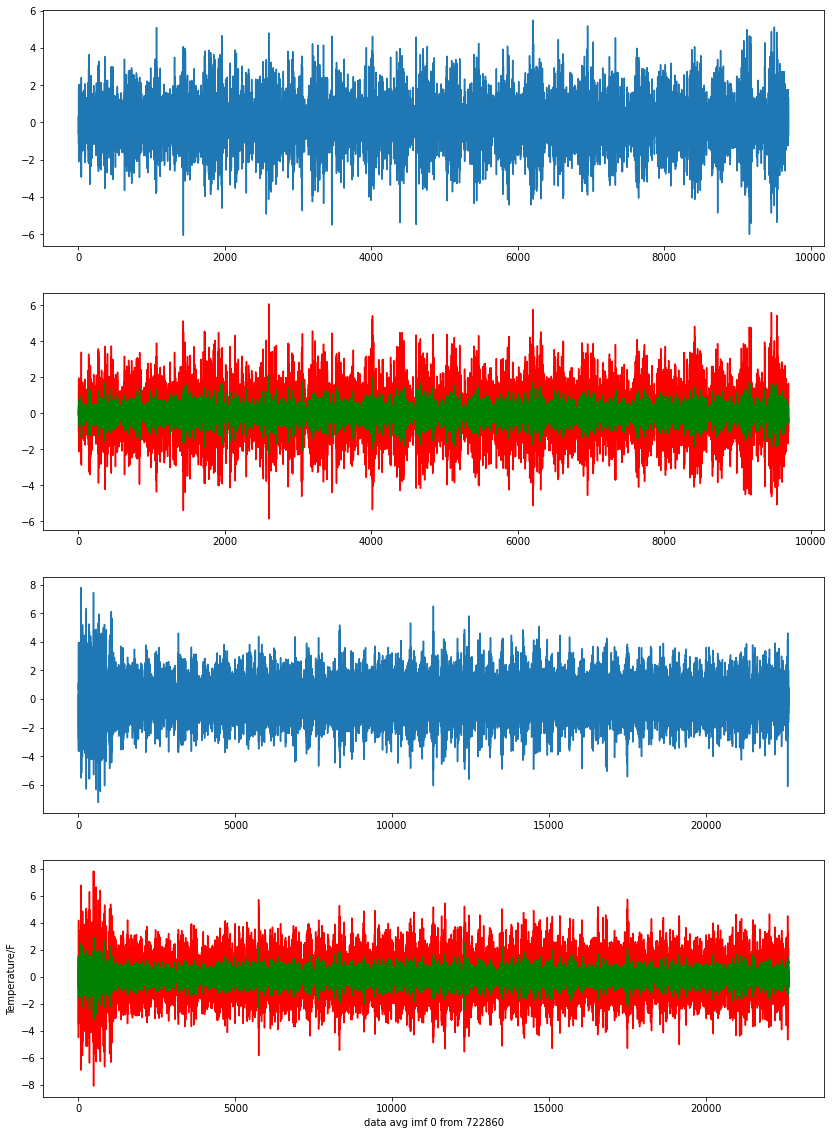

Epoch:0
MSE
TRAIN:1.7946957242103847	TEST:1.8904919139331353
Base_line:36.60765783144048	DIFFERENT:34.717165917507344
TARGET:2.440510522096032
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf0.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2

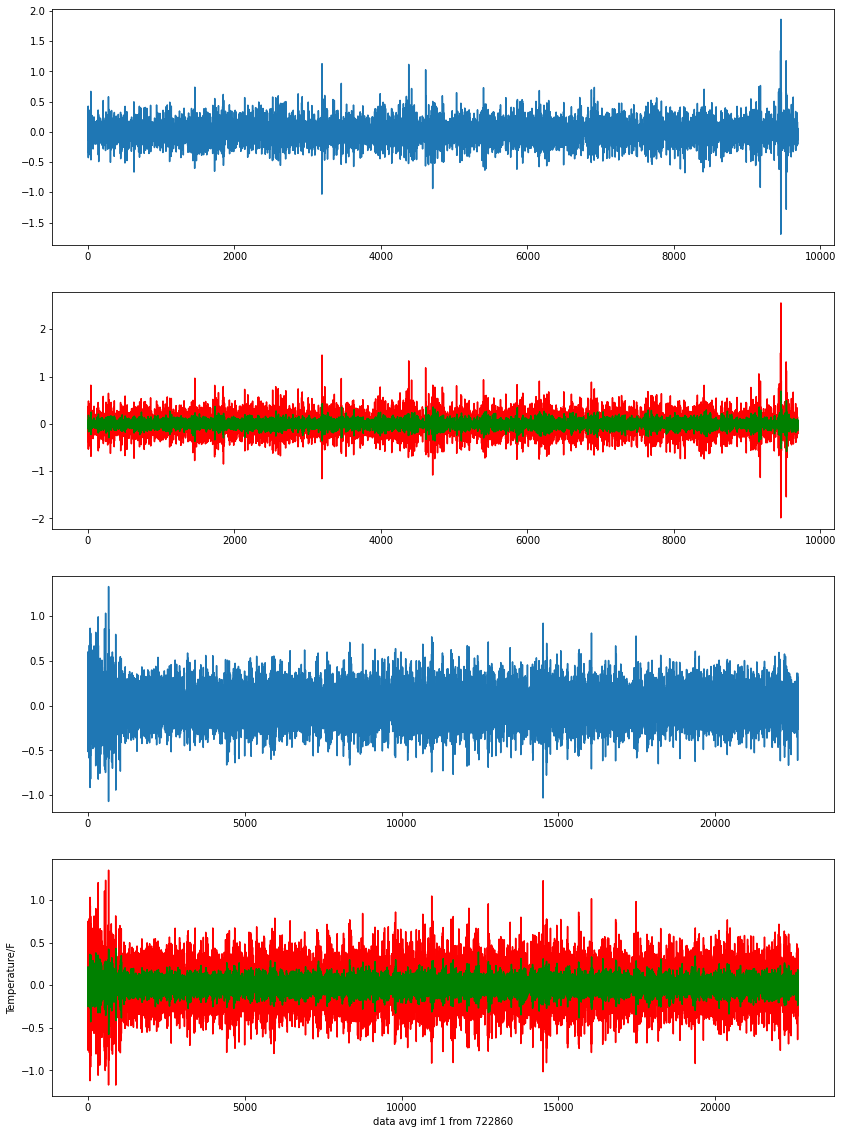

Epoch:0
MSE
TRAIN:0.03297447903694023	TEST:0.03552879257973097
Base_line:0.5396982567908181	DIFFERENT:0.5041694642110871
TARGET:0.038549875485058435
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf1.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
d

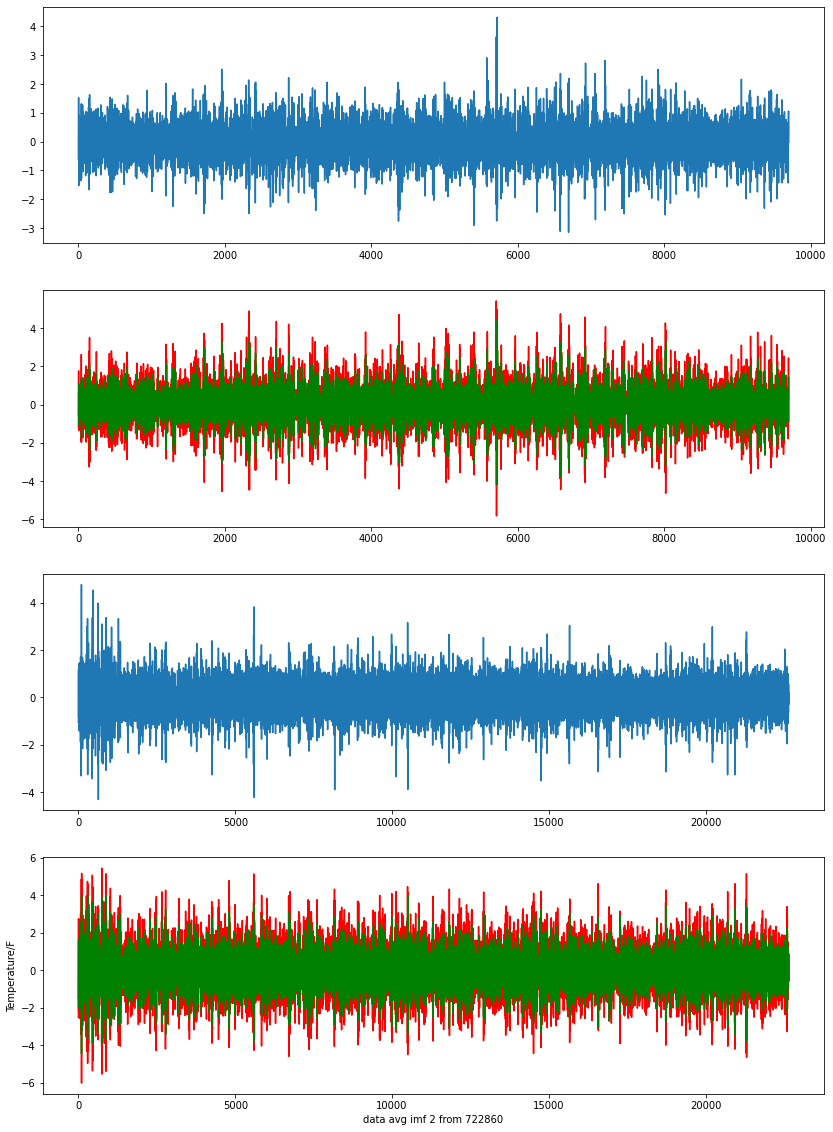

Epoch:0
MSE
TRAIN:0.4611912243246812	TEST:0.4527761243620223
Base_line:7.982091224884697	DIFFERENT:7.529315100522675
TARGET:0.6140070172988229
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf2.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2

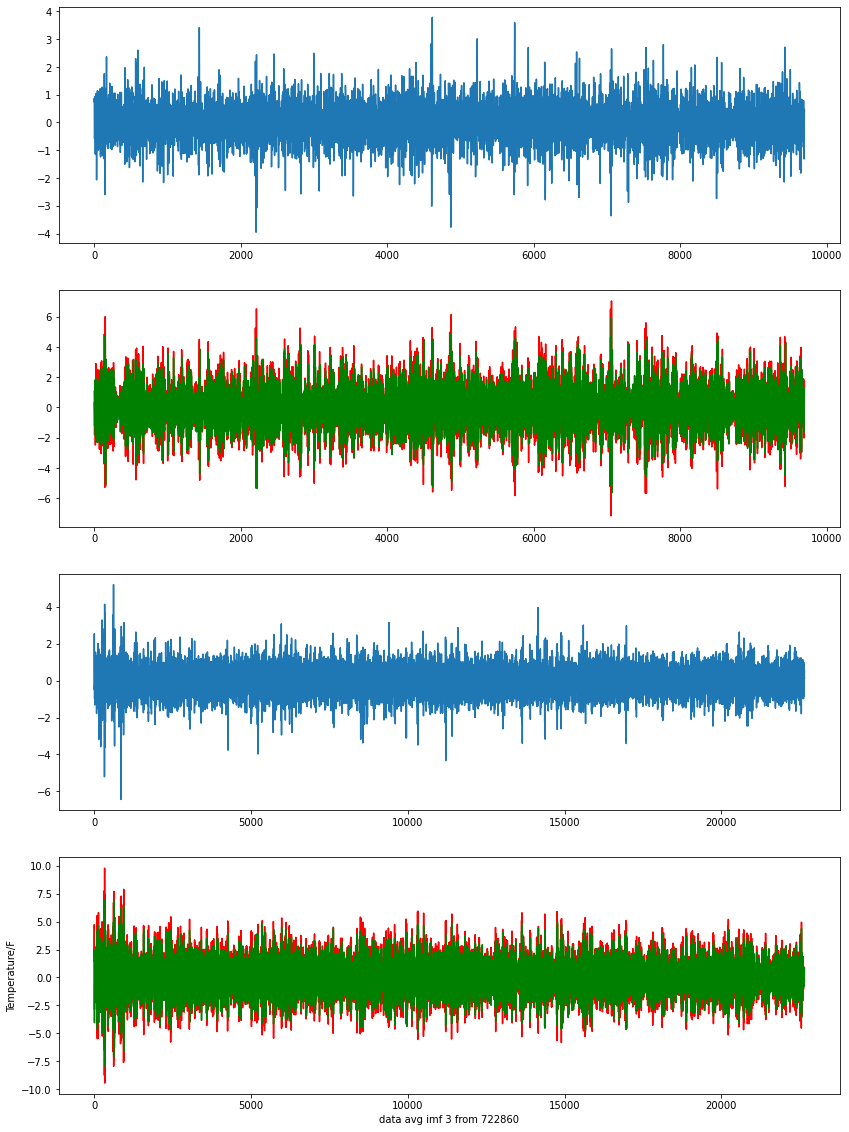

Epoch:1
MSE
TRAIN:0.565426853649678	TEST:0.552586584734078
Base_line:7.117348346053934	DIFFERENT:6.564761761319856
TARGET:0.5931123621711611
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf3.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (

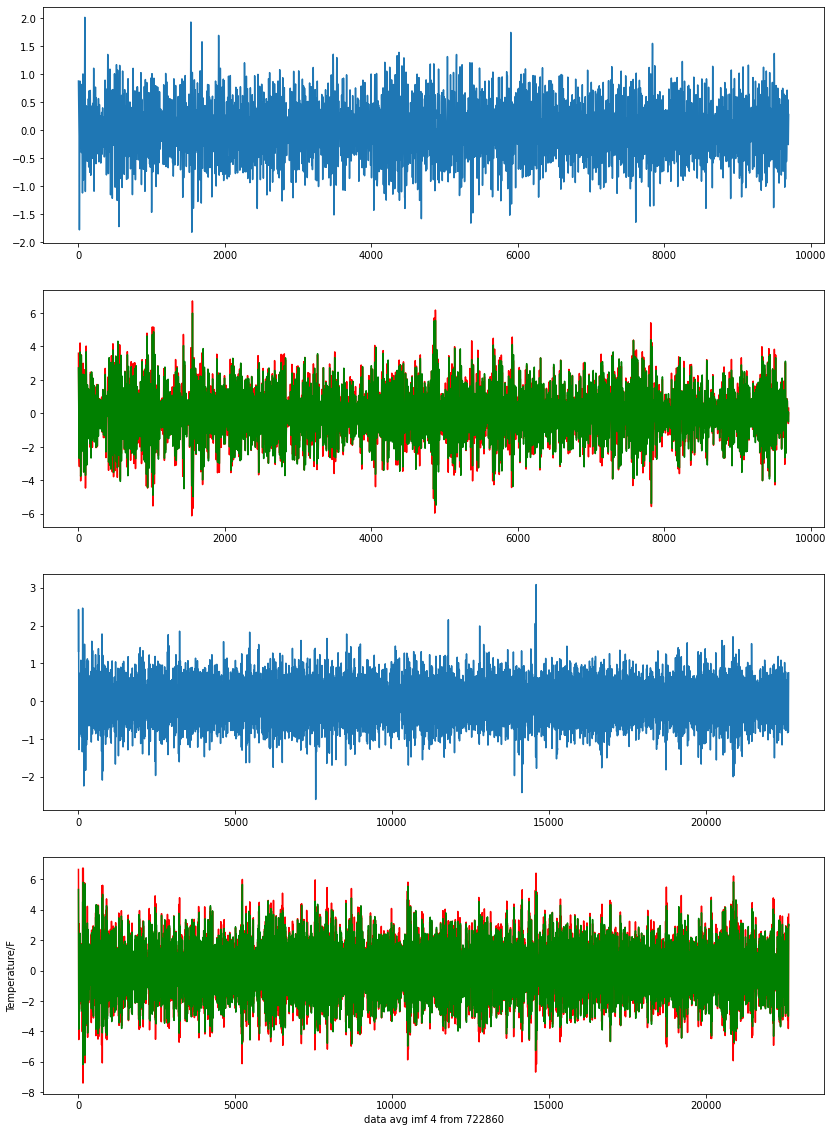

Epoch:6
MSE
TRAIN:0.27227972305057657	TEST:0.2415283427151538
Base_line:2.694526784656787	DIFFERENT:2.452998441941633
TARGET:0.24495698042334427
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf4.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense

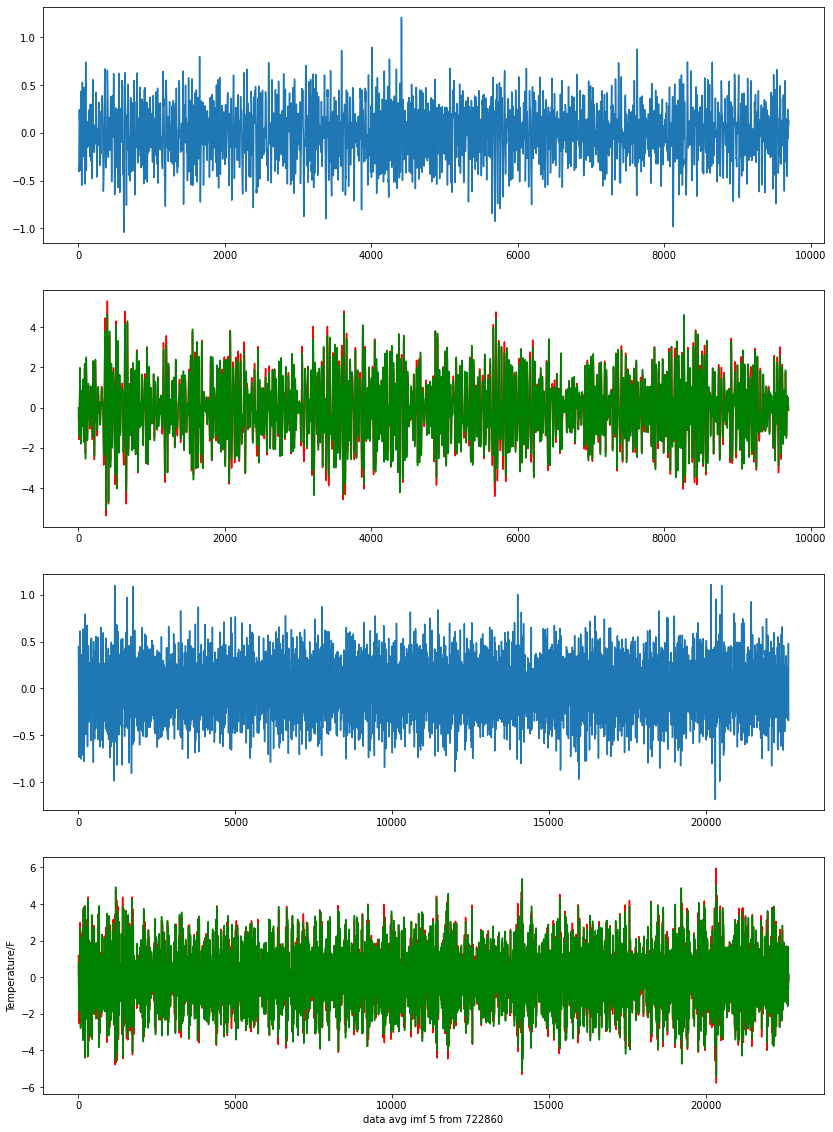

Epoch:16
MSE
TRAIN:0.07989305532274399	TEST:0.07971384575005791
Base_line:0.8085011220542202	DIFFERENT:0.7287872763041623
TARGET:0.08085011220542201
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf5.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
d

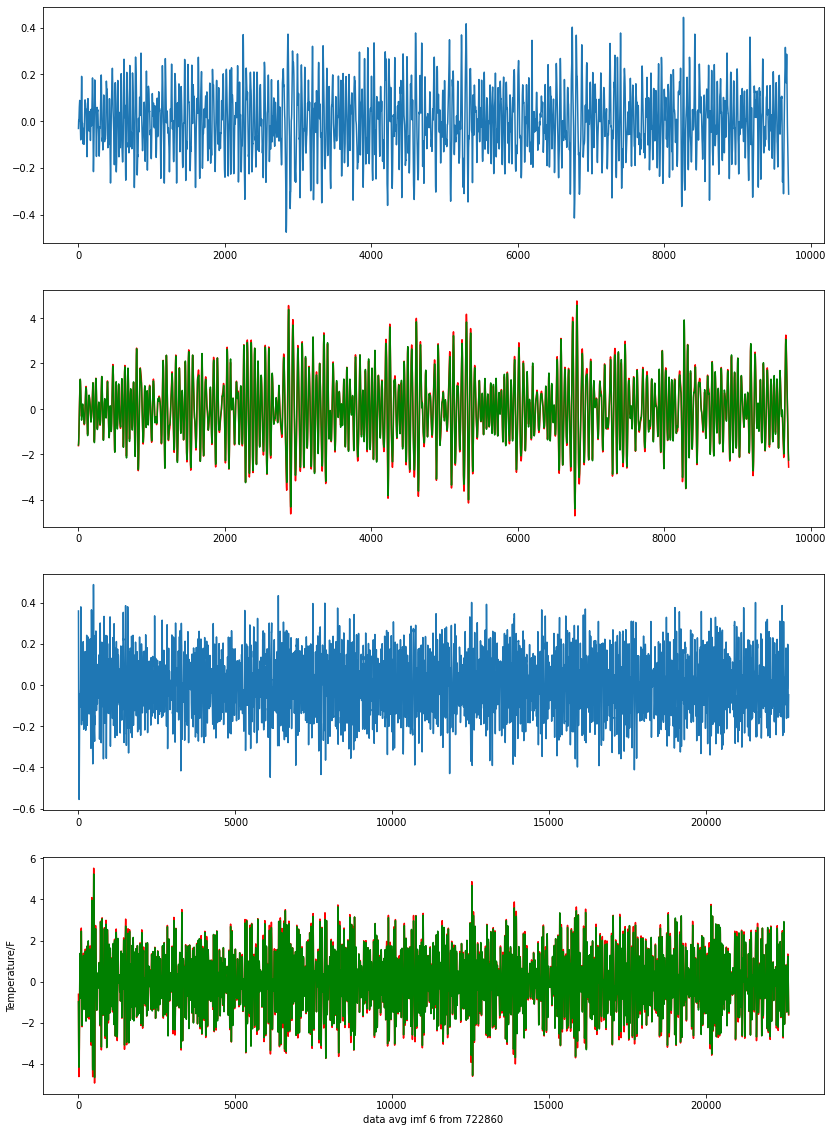

Epoch:3
MSE
TRAIN:0.0199388999410949	TEST:0.019298893378811664
Base_line:0.21594720848912002	DIFFERENT:0.19664831511030836
TARGET:0.023994134276568893
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf6.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________

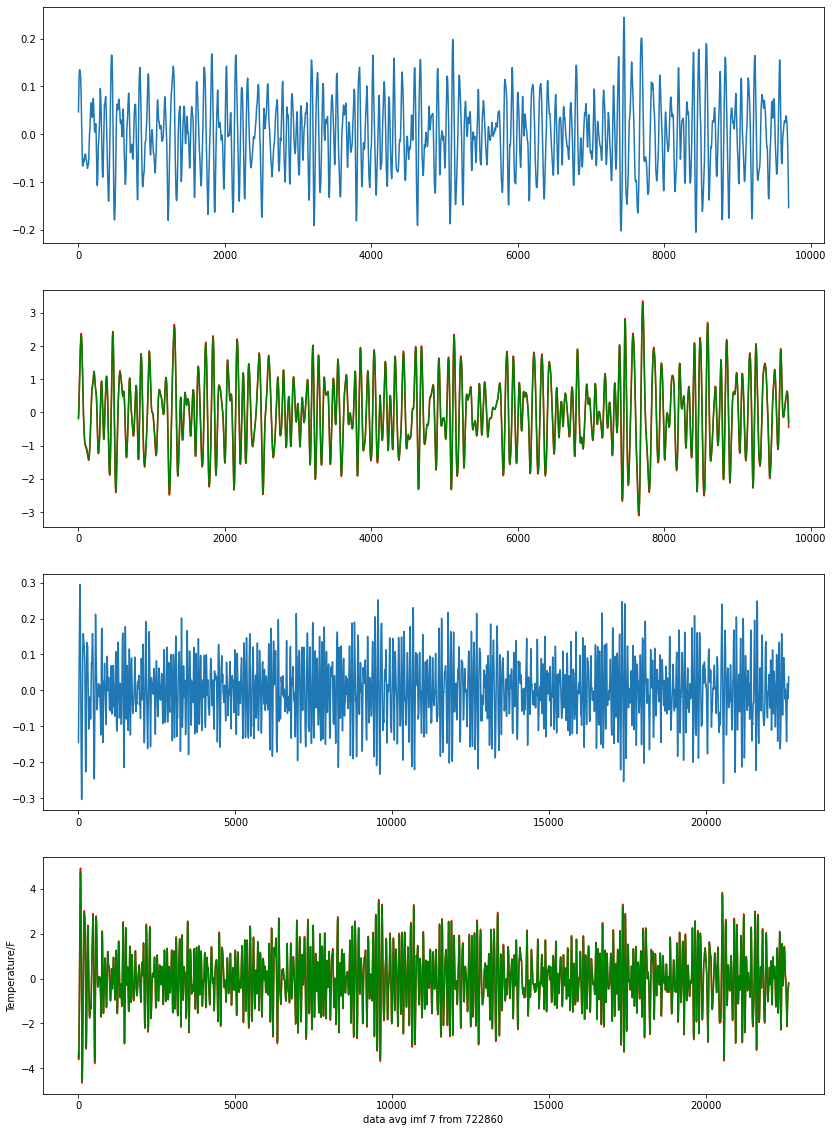

Epoch:16
MSE
TRAIN:0.0073967987013994485	TEST:0.005720483500138685
Base_line:0.047794599534392336	DIFFERENT:0.04207411603425365
TARGET:0.005974324941799042
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf7.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
____________________________________________________________

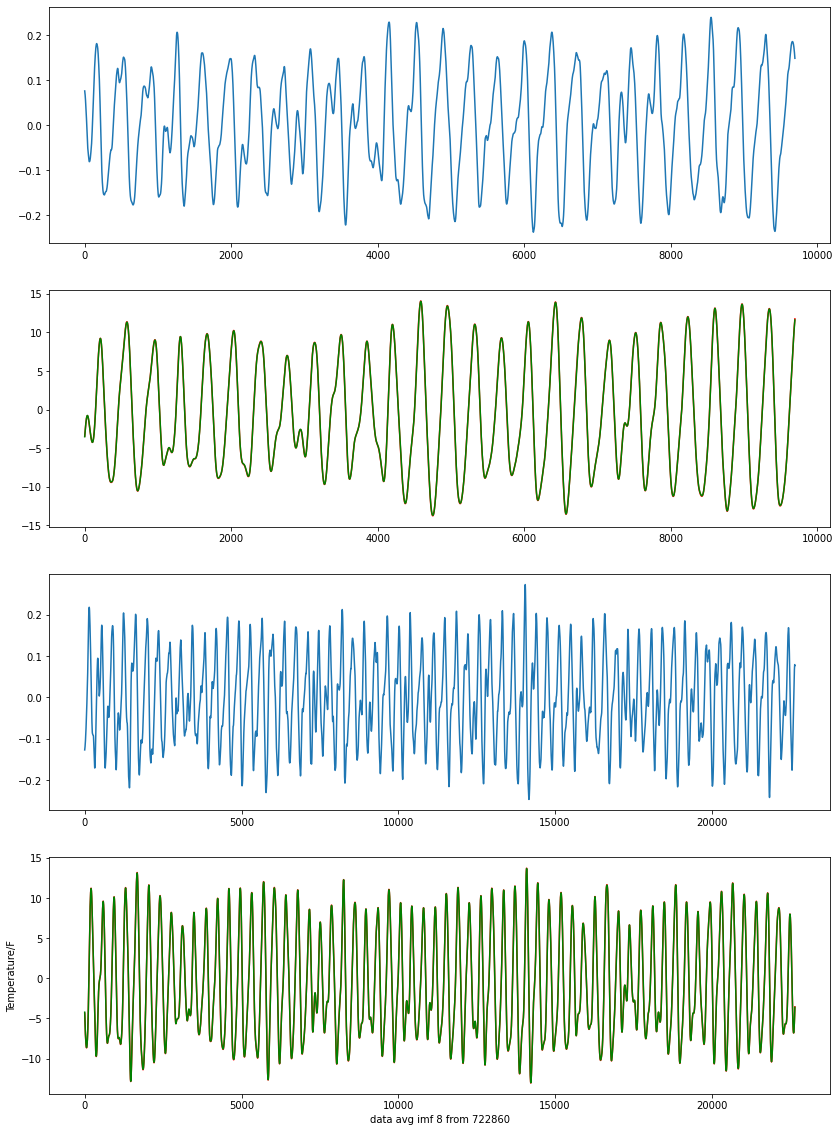

Epoch:9
MSE
TRAIN:0.011282784719767548	TEST:0.01345725639496789
Base_line:0.1079888929510919	DIFFERENT:0.09453163655612401
TARGET:0.015426984707298844
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf8.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________

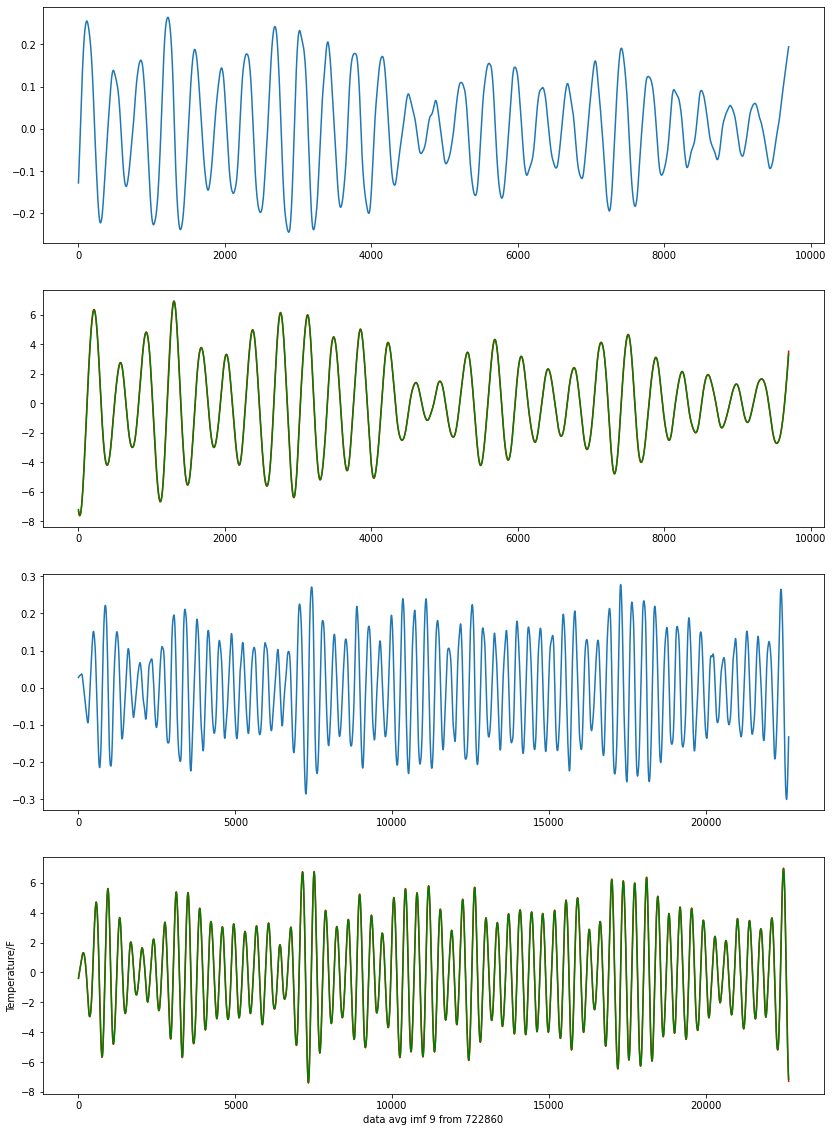

Epoch:20
MSE
TRAIN:0.015426820321813728	TEST:0.013410109205798116
Base_line:0.018747933068020882	DIFFERENT:0.005337823862222766
TARGET:0.0031246555113368137
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf9.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
___________________________________________________________

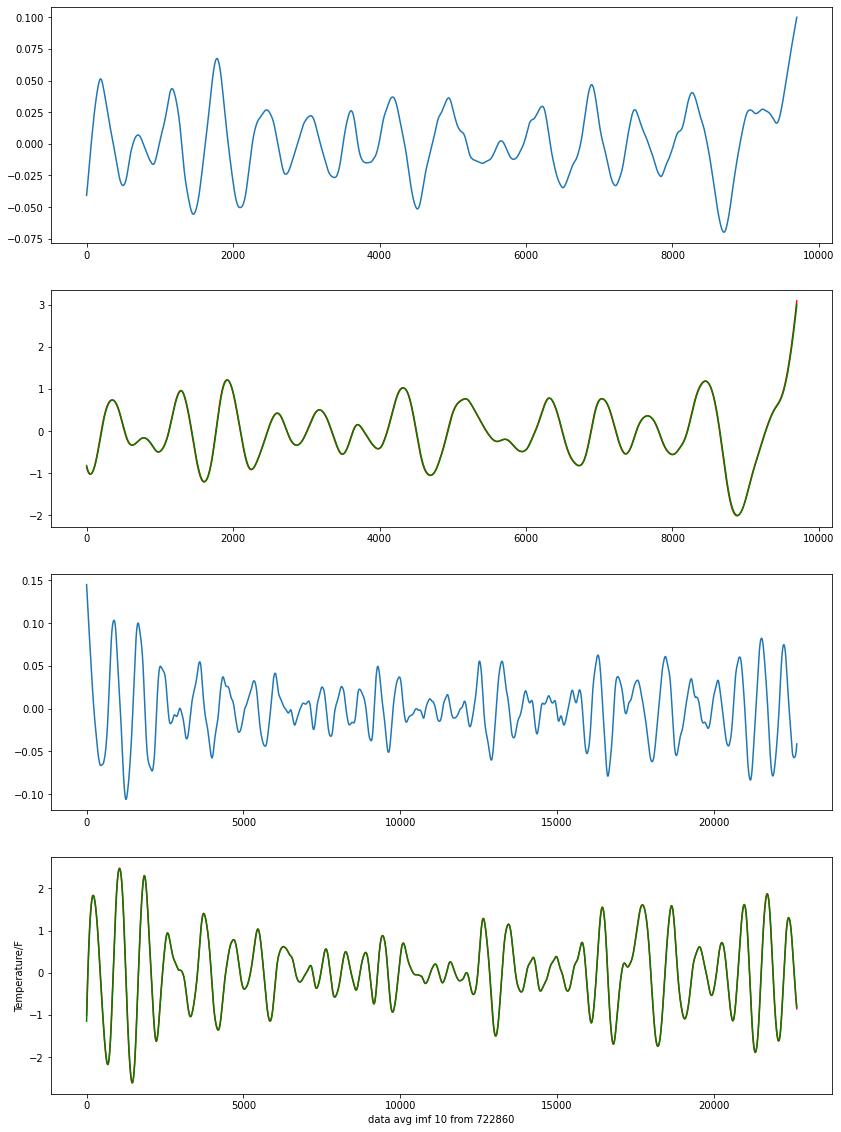

Epoch:20
MSE
TRAIN:0.001249015354112489	TEST:0.0007466281058028358
Base_line:0.0003331785824119925	DIFFERENT:0.00041344952339084334
TARGET:6.66357164823985e-05
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf10.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________________________

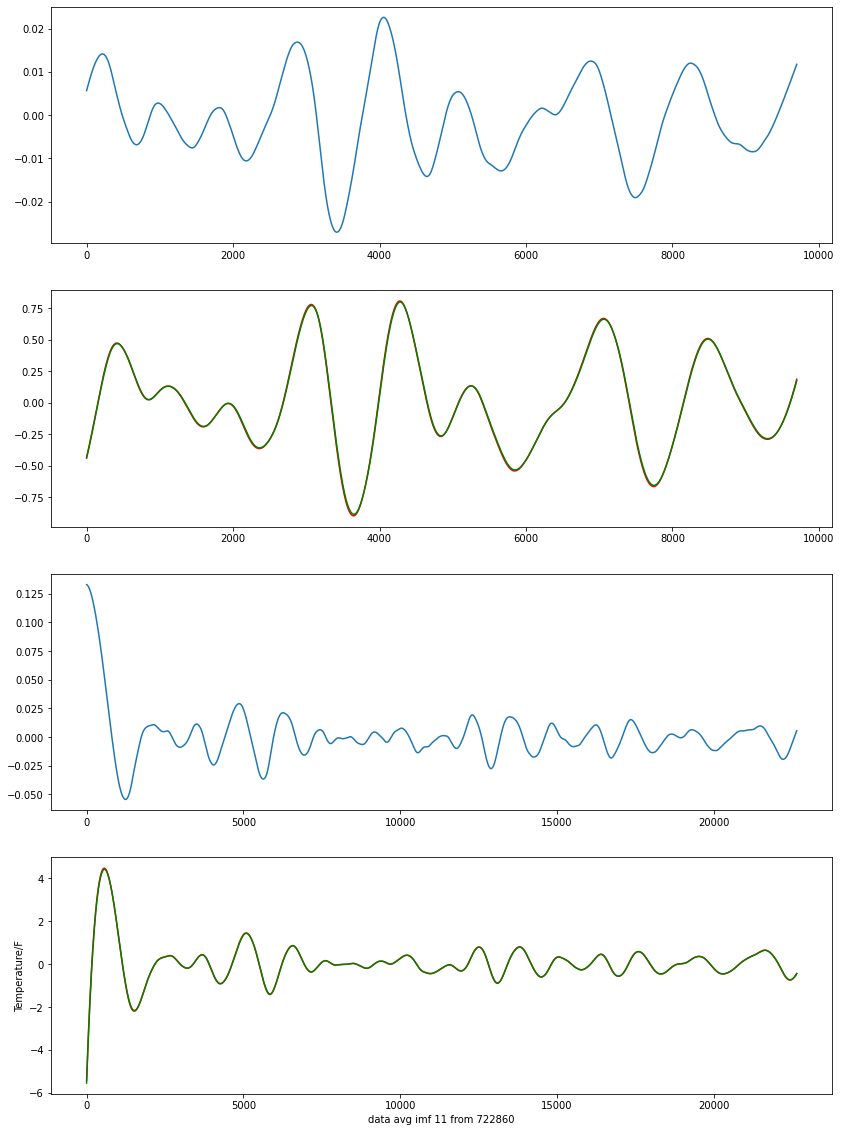

Epoch:20
MSE
TRAIN:0.00046222749025975223	TEST:9.804295379203465e-05
Base_line:0.00012467399085482622	DIFFERENT:2.663103706279158e-05
TARGET:3.1168497713706556e-05
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf11.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
___________________________________________________

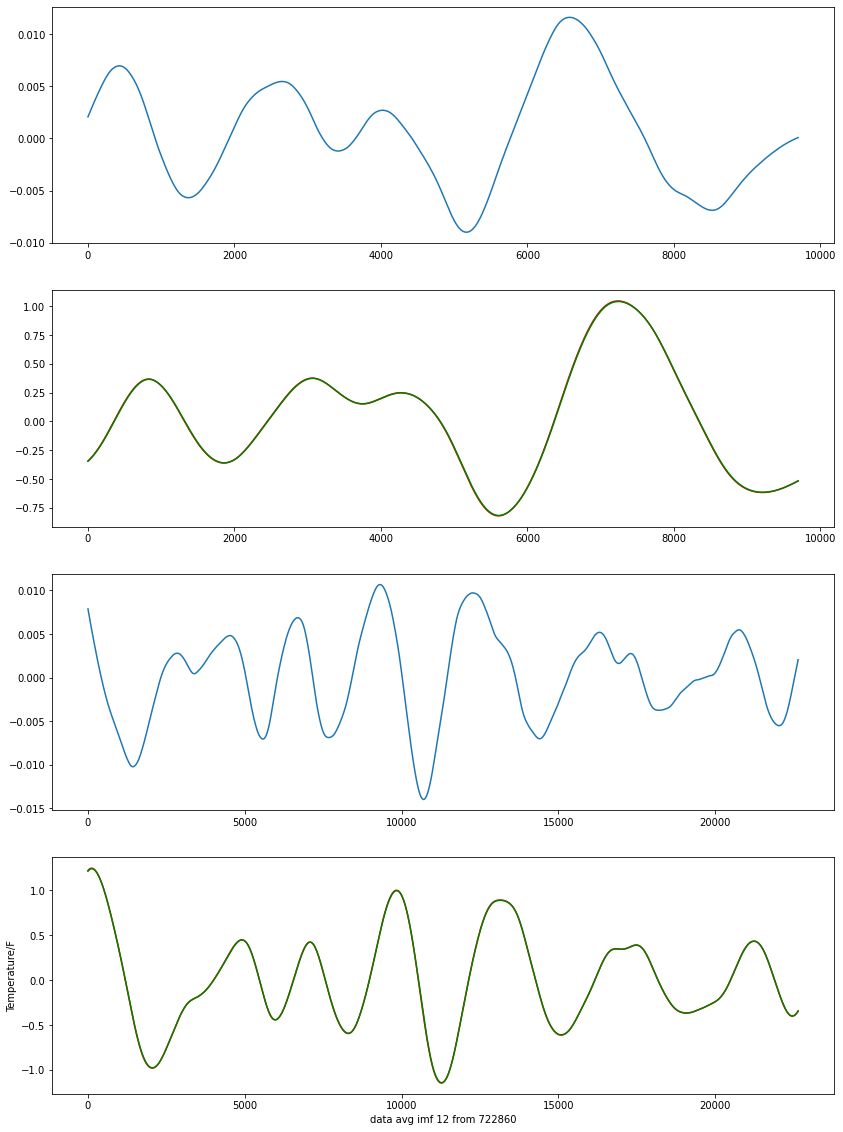

Epoch:20
MSE
TRAIN:2.772867930487809e-05	TEST:2.659375857011321e-05
Base_line:6.076759829725643e-06	DIFFERENT:2.0516998740387567e-05
TARGET:2.0255866099085476e-06
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf12.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
____________________________________________________

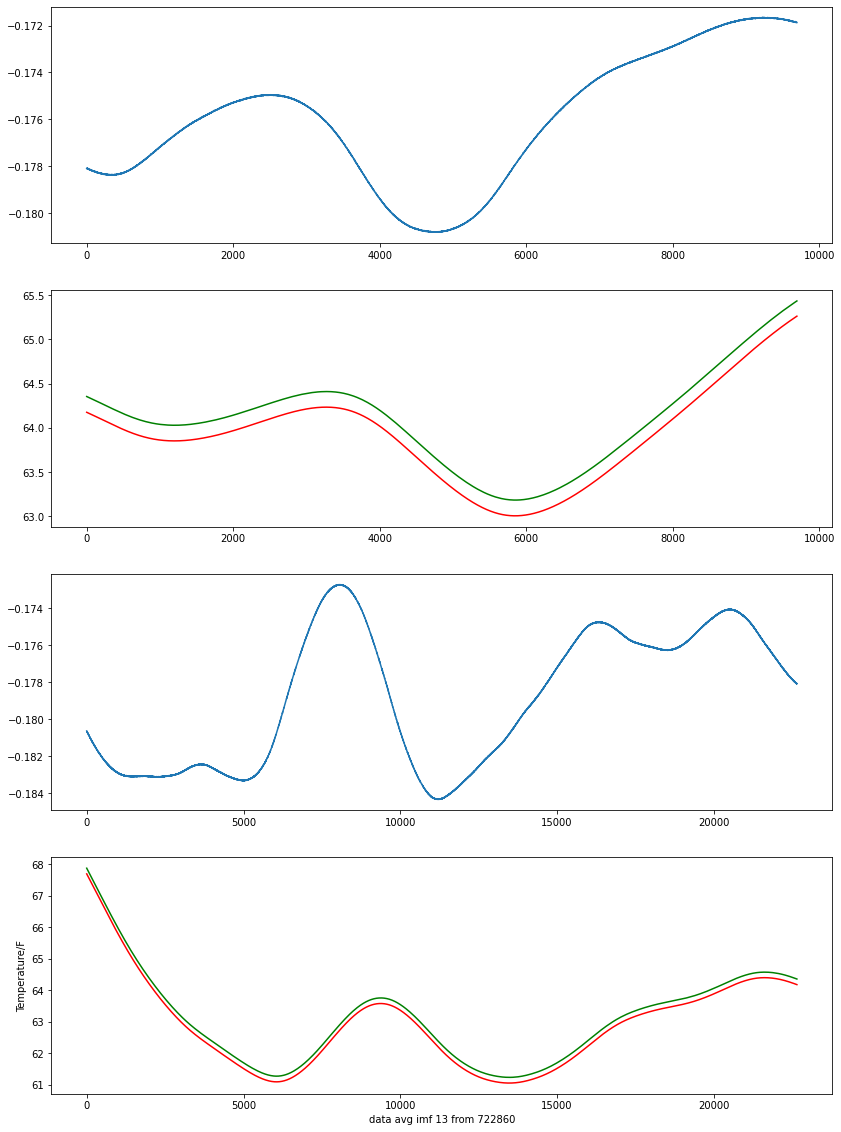

Epoch:20
MSE
TRAIN:0.03200821935405398	TEST:0.03100062008170432
Base_line:4.672627892704426e-06	DIFFERENT:0.030995947453811616
TARGET:2.336313946352213e-06
INFO:tensorflow:Assets written to: ./tf_model_params_1628057222.612672/722860_avg_imf13.params/assets
-------------------------------------------------------------------


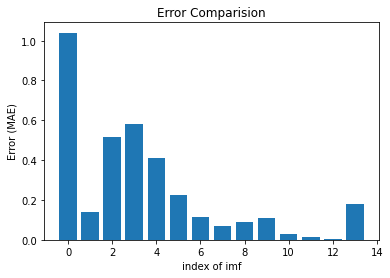

In [8]:
train("avg")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
____________________________________________________

707/707 [==============================] - 1s 751us/step - loss: 6.3921
Epoch 85/100
707/707 [==============================] - 1s 735us/step - loss: 6.3973
Epoch 86/100
707/707 [==============================] - 1s 745us/step - loss: 6.4371
Epoch 87/100
707/707 [==============================] - 1s 747us/step - loss: 6.5015
Epoch 88/100
707/707 [==============================] - 1s 776us/step - loss: 6.3483
Epoch 89/100
707/707 [==============================] - 1s 935us/step - loss: 6.3426
Epoch 90/100
707/707 [==============================] - 1s 811us/step - loss: 6.3967
Epoch 91/100
707/707 [==============================] - 1s 907us/step - loss: 6.3758
Epoch 92/100
707/707 [==============================] - 1s 814us/step - loss: 6.4000
Epoch 93/100
707/707 [==============================] - 1s 710us/step - loss: 6.4243
Epoch 94/100
707/707 [==============================] - 1s 719us/step - loss: 6.4161
Epoch 95/100
707/707 [==============================] - 1s 713us/step - loss: 

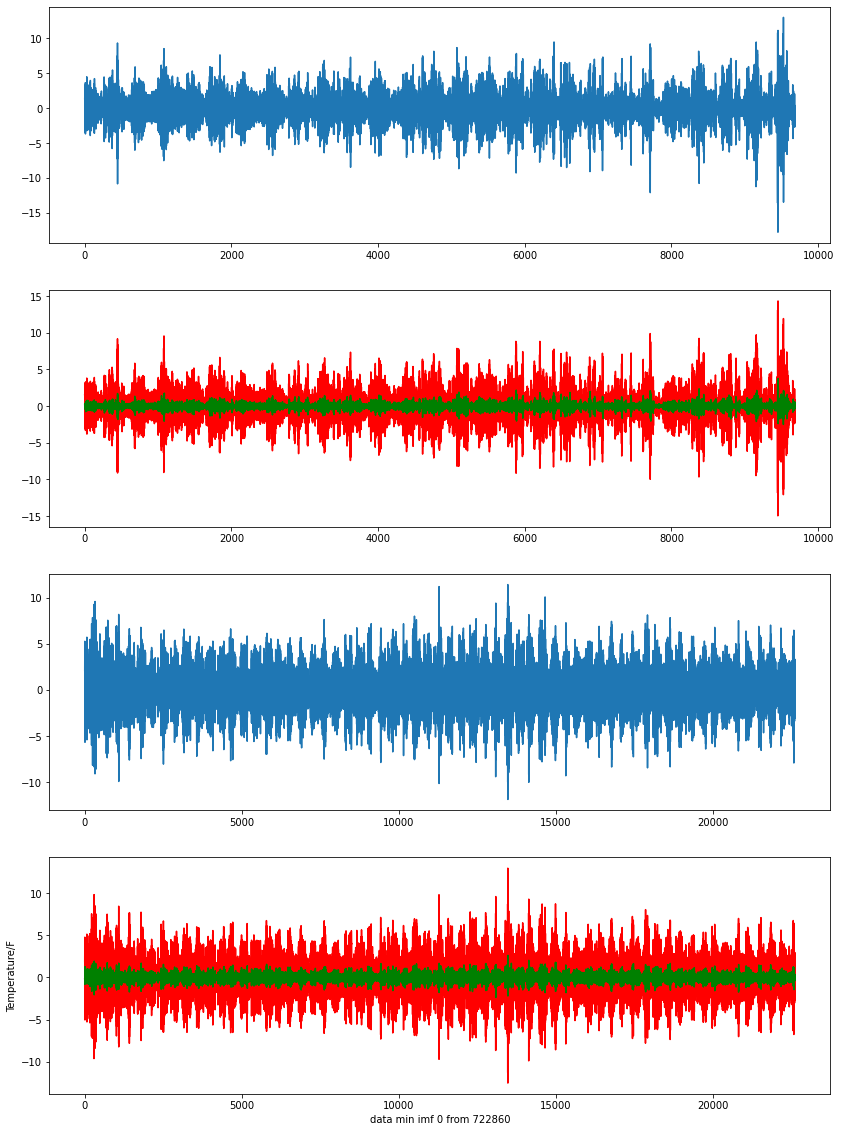

Epoch:0
MSE
TRAIN:6.111093449579998	TEST:6.348978727701133
Base_line:113.17741795572803	DIFFERENT:106.8284392280269
TARGET:8.084101282552002
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf0.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (

707/707 [==============================] - 1s 827us/step - loss: 3.4572
Epoch 81/100
707/707 [==============================] - 1s 751us/step - loss: 3.3722
Epoch 82/100
707/707 [==============================] - 1s 759us/step - loss: 3.5197
Epoch 83/100
707/707 [==============================] - 1s 745us/step - loss: 3.3550
Epoch 84/100
707/707 [==============================] - 1s 748us/step - loss: 3.3189
Epoch 85/100
707/707 [==============================] - 1s 735us/step - loss: 3.4222
Epoch 86/100
707/707 [==============================] - 1s 728us/step - loss: 3.3575
Epoch 87/100
707/707 [==============================] - 1s 719us/step - loss: 3.4152
Epoch 88/100
707/707 [==============================] - 1s 738us/step - loss: 3.3904
Epoch 89/100
707/707 [==============================] - 1s 727us/step - loss: 3.3574
Epoch 90/100
707/707 [==============================] - 1s 756us/step - loss: 3.3331
Epoch 91/100
707/707 [==============================] - 1s 759us/step - loss: 

707/707 [==============================] - 1s 770us/step - loss: 3.2952
Epoch 21/25
707/707 [==============================] - 1s 767us/step - loss: 3.2861
Epoch 22/25
707/707 [==============================] - 1s 738us/step - loss: 3.2902
Epoch 23/25
707/707 [==============================] - 1s 877us/step - loss: 3.2753
Epoch 24/25
707/707 [==============================] - 1s 842us/step - loss: 3.2878
Epoch 25/25
707/707 [==============================] - 1s 874us/step - loss: 3.2783
Epoch:4
MSE
TRAIN:3.0901433715372915	TEST:3.966234685138879
Base_line:29.622574250740517	DIFFERENT:25.656339565601638
TARGET:2.2786595577492705
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 792us/step - loss: 3.2523
Epoch 2/25
707/707 [==============================] - 1s 1ms/step - loss: 3.2900
Epoch 3/25
707/707 [==============================] - 1s 851us/step - loss: 3.2894
Epoch 4/25
707/707 [==============================] - 1s 821us/step - loss: 3.2893
Epoch 5/25
707/707 [=====

707/707 [==============================] - 1s 732us/step - loss: 3.2375
Epoch 10/25
707/707 [==============================] - 1s 758us/step - loss: 3.2215
Epoch 11/25
707/707 [==============================] - 1s 918us/step - loss: 3.2382
Epoch 12/25
707/707 [==============================] - 1s 741us/step - loss: 3.2308
Epoch 13/25
707/707 [==============================] - 1s 803us/step - loss: 3.2005
Epoch 14/25
707/707 [==============================] - 1s 815us/step - loss: 3.2276
Epoch 15/25
707/707 [==============================] - 1s 941us/step - loss: 3.2418 0s - loss: 3.239
Epoch 16/25
707/707 [==============================] - 1s 883us/step - loss: 3.2430
Epoch 17/25
707/707 [==============================] - 1s 809us/step - loss: 3.2180
Epoch 18/25
707/707 [==============================] - 1s 741us/step - loss: 3.2445
Epoch 19/25
707/707 [==============================] - 1s 756us/step - loss: 3.2267
Epoch 20/25
707/707 [==============================] - 1s 820us/step - 

707/707 [==============================] - 1s 899us/step - loss: 3.2032


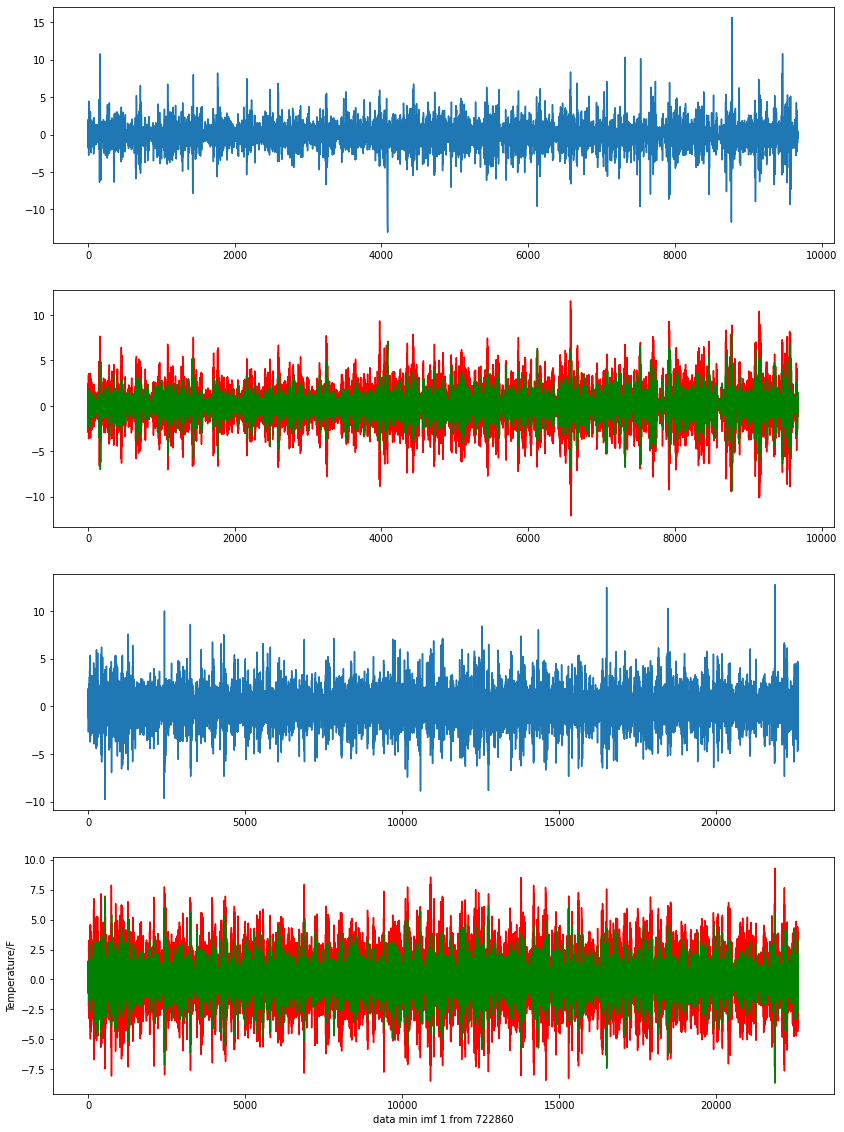

Epoch:10
MSE
TRAIN:3.0459902420404656	TEST:3.876499349282325
Base_line:29.622574250740517	DIFFERENT:25.74607490145819
TARGET:2.2786595577492705
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf1.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_

707/707 [==============================] - 1s 765us/step - loss: 1.8390
Epoch 81/100
707/707 [==============================] - 0s 702us/step - loss: 1.8018
Epoch 82/100
707/707 [==============================] - 1s 711us/step - loss: 1.8195
Epoch 83/100
707/707 [==============================] - 1s 712us/step - loss: 1.8363
Epoch 84/100
707/707 [==============================] - 0s 704us/step - loss: 1.7970
Epoch 85/100
707/707 [==============================] - 1s 819us/step - loss: 1.7945
Epoch 86/100
707/707 [==============================] - 1s 741us/step - loss: 1.7890
Epoch 87/100
707/707 [==============================] - 1s 799us/step - loss: 1.7448
Epoch 88/100
707/707 [==============================] - 1s 750us/step - loss: 1.7272
Epoch 89/100
707/707 [==============================] - 1s 760us/step - loss: 1.7634
Epoch 90/100
707/707 [==============================] - 1s 788us/step - loss: 1.7921
Epoch 91/100
707/707 [==============================] - 1s 812us/step - loss: 

707/707 [==============================] - 1s 728us/step - loss: 1.4729
Epoch 21/25
707/707 [==============================] - 1s 752us/step - loss: 1.4757
Epoch 22/25
707/707 [==============================] - 1s 751us/step - loss: 1.4883
Epoch 23/25
707/707 [==============================] - 1s 749us/step - loss: 1.4723
Epoch 24/25
707/707 [==============================] - 1s 755us/step - loss: 1.4706
Epoch 25/25
707/707 [==============================] - 1s 832us/step - loss: 1.4613
Epoch:4
MSE
TRAIN:1.2418434951096606	TEST:1.3057452352271173
Base_line:8.869784496146105	DIFFERENT:7.564039260918987
TARGET:0.7391487080121754
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 958us/step - loss: 1.4722
Epoch 2/25
707/707 [==============================] - 1s 1000us/step - loss: 1.4503
Epoch 3/25
707/707 [==============================] - 1s 1ms/step - loss: 1.4566
Epoch 4/25
707/707 [==============================] - 1s 1ms/step - loss: 1.4357
Epoch 5/25
707/707 [=======

707/707 [==============================] - 1s 726us/step - loss: 1.3054
Epoch 11/25
707/707 [==============================] - 1s 721us/step - loss: 1.3225
Epoch 12/25
707/707 [==============================] - 1s 855us/step - loss: 1.3130
Epoch 13/25
707/707 [==============================] - 1s 780us/step - loss: 1.3115
Epoch 14/25
707/707 [==============================] - 1s 1ms/step - loss: 1.3186
Epoch 15/25
707/707 [==============================] - 1s 797us/step - loss: 1.3004
Epoch 16/25
707/707 [==============================] - 1s 817us/step - loss: 1.2986
Epoch 17/25
707/707 [==============================] - 1s 854us/step - loss: 1.3242
Epoch 18/25
707/707 [==============================] - 1s 767us/step - loss: 1.2950
Epoch 19/25
707/707 [==============================] - 1s 734us/step - loss: 1.2947
Epoch 20/25
707/707 [==============================] - 1s 761us/step - loss: 1.2932
Epoch 21/25
707/707 [==============================] - 1s 776us/step - loss: 1.2733
Epoch 

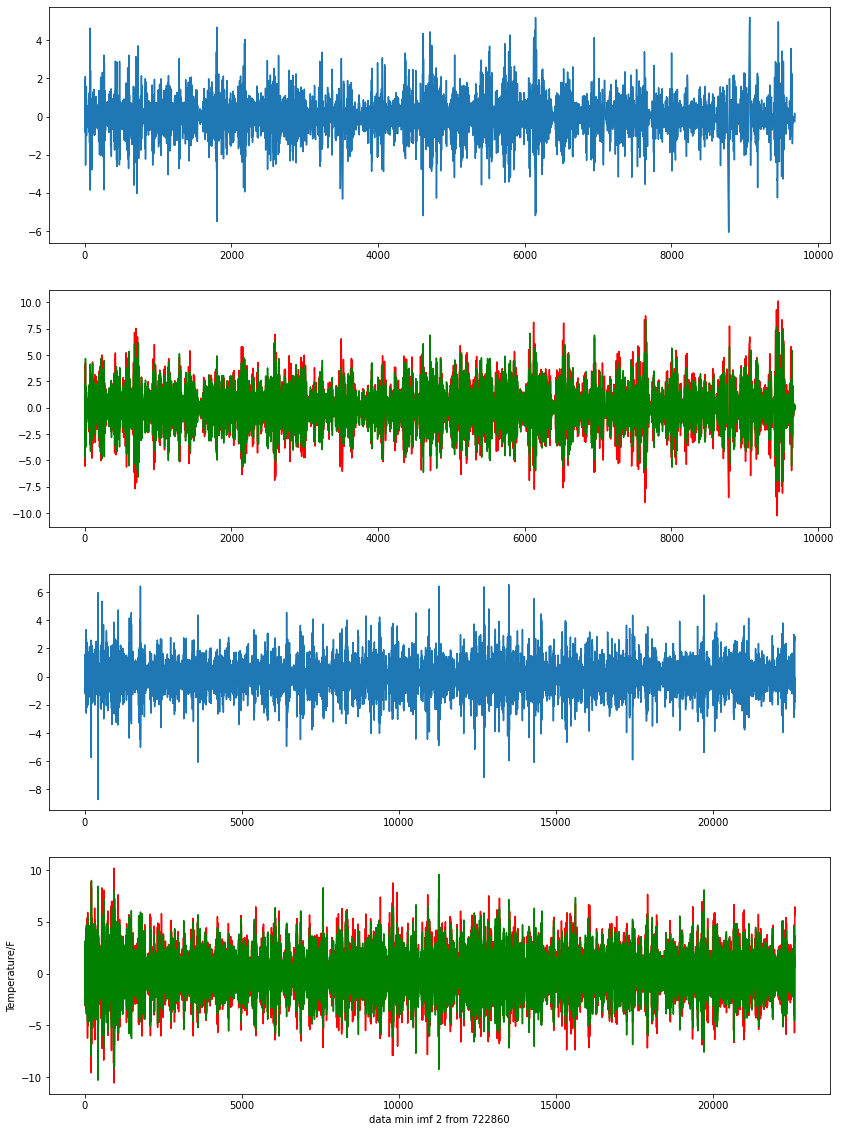

Epoch:10
MSE
TRAIN:1.0454171830242567	TEST:1.077536221174522
Base_line:8.869784496146105	DIFFERENT:7.792248274971582
TARGET:0.7391487080121754
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf2.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2

707/707 [==============================] - 1s 902us/step - loss: 0.7288
Epoch 81/100
707/707 [==============================] - 1s 896us/step - loss: 0.7443
Epoch 82/100
707/707 [==============================] - 1s 941us/step - loss: 0.7289
Epoch 83/100
707/707 [==============================] - 1s 975us/step - loss: 0.7273
Epoch 84/100
707/707 [==============================] - 1s 987us/step - loss: 0.7241
Epoch 85/100
707/707 [==============================] - 1s 847us/step - loss: 0.7266
Epoch 86/100
707/707 [==============================] - 1s 882us/step - loss: 0.7009
Epoch 87/100
707/707 [==============================] - 1s 924us/step - loss: 0.7038
Epoch 88/100
707/707 [==============================] - 1s 947us/step - loss: 0.7110
Epoch 89/100
707/707 [==============================] - 1s 952us/step - loss: 0.7007
Epoch 90/100
707/707 [==============================] - 1s 815us/step - loss: 0.7272
Epoch 91/100
707/707 [==============================] - 1s 934us/step - loss: 

707/707 [==============================] - 1s 873us/step - loss: 0.5152
Epoch 21/25
707/707 [==============================] - 1s 790us/step - loss: 0.5271
Epoch 22/25
707/707 [==============================] - 1s 849us/step - loss: 0.5120
Epoch 23/25
707/707 [==============================] - 1s 801us/step - loss: 0.5141 0s - loss: 0
Epoch 24/25
707/707 [==============================] - 1s 884us/step - loss: 0.5078
Epoch 25/25
707/707 [==============================] - 1s 831us/step - loss: 0.5051
Epoch:4
MSE
TRAIN:0.33572928867217455	TEST:0.4136270587101822
Base_line:2.256633203471402	DIFFERENT:1.8430061447612196
TARGET:0.20514847304285472
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 769us/step - loss: 0.5186
Epoch 2/25
707/707 [==============================] - 1s 792us/step - loss: 0.5172
Epoch 3/25
707/707 [==============================] - 1s 797us/step - loss: 0.5078
Epoch 4/25
707/707 [==============================] - 1s 847us/step - loss: 0.5084
Epoch 5/

707/707 [==============================] - 1s 1ms/step - loss: 0.4227
Epoch 11/25
707/707 [==============================] - 1s 1ms/step - loss: 0.4129
Epoch 12/25
707/707 [==============================] - 1s 1ms/step - loss: 0.4200A: 0s - l
Epoch 13/25
707/707 [==============================] - 1s 976us/step - loss: 0.4186
Epoch 14/25
707/707 [==============================] - 1s 1ms/step - loss: 0.4255
Epoch 15/25
707/707 [==============================] - 1s 2ms/step - loss: 0.4171
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 0.4122
Epoch 17/25
707/707 [==============================] - 1s 1ms/step - loss: 0.4131
Epoch 18/25
707/707 [==============================] - 1s 803us/step - loss: 0.4202
Epoch 19/25
707/707 [==============================] - 1s 997us/step - loss: 0.4120
Epoch 20/25
707/707 [==============================] - 1s 1ms/step - loss: 0.4128
Epoch 21/25
707/707 [==============================] - 1s 902us/step - loss: 0.4149
Epoch 22/25

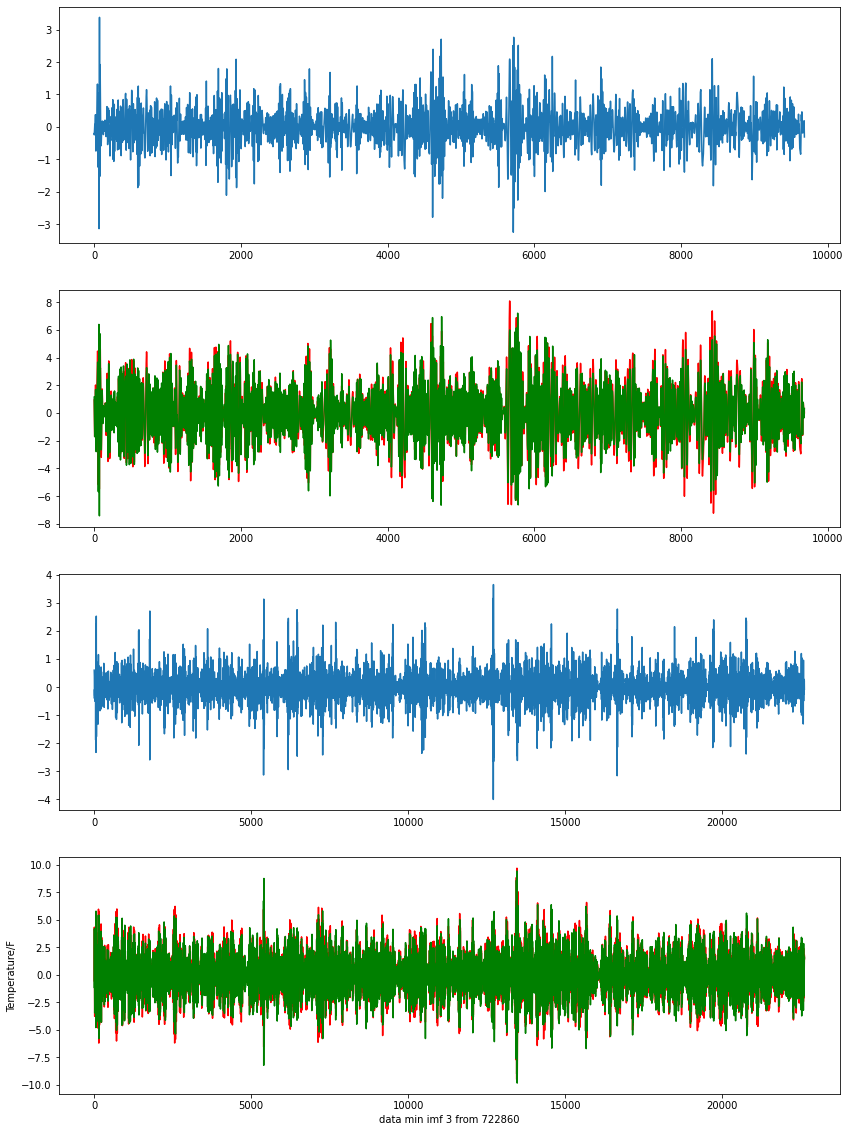

Epoch:10
MSE
TRAIN:0.23755005183706643	TEST:0.27668814251892715
Base_line:2.256633203471402	DIFFERENT:1.9799450609524747
TARGET:0.20514847304285472
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf3.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
de

707/707 [==============================] - 1s 776us/step - loss: 0.2926
Epoch 81/100
707/707 [==============================] - 1s 875us/step - loss: 0.2861
Epoch 82/100
707/707 [==============================] - 1s 855us/step - loss: 0.2828
Epoch 83/100
707/707 [==============================] - 1s 861us/step - loss: 0.2894
Epoch 84/100
707/707 [==============================] - 1s 856us/step - loss: 0.2882
Epoch 85/100
707/707 [==============================] - 1s 798us/step - loss: 0.2880
Epoch 86/100
707/707 [==============================] - 1s 788us/step - loss: 0.2953
Epoch 87/100
707/707 [==============================] - 1s 825us/step - loss: 0.2866
Epoch 88/100
707/707 [==============================] - 1s 833us/step - loss: 0.2761
Epoch 89/100
707/707 [==============================] - 1s 752us/step - loss: 0.2797
Epoch 90/100
707/707 [==============================] - 1s 754us/step - loss: 0.2851
Epoch 91/100
707/707 [==============================] - 1s 863us/step - loss: 

707/707 [==============================] - 1s 1ms/step - loss: 0.2432
Epoch 21/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2441
Epoch 22/25
707/707 [==============================] - 1s 914us/step - loss: 0.2446
Epoch 23/25
707/707 [==============================] - 1s 900us/step - loss: 0.2381
Epoch 24/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2445
Epoch 25/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2382
Epoch:4
MSE
TRAIN:0.12321243683509672	TEST:0.11569188675775788
Base_line:0.6154088489216128	DIFFERENT:0.49971696216385497
TARGET:0.061540884892161286
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 2ms/step - loss: 0.2397
Epoch 2/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2384
Epoch 3/25
707/707 [==============================] - 1s 943us/step - loss: 0.2425
Epoch 4/25
707/707 [==============================] - 1s 885us/step - loss: 0.2408
Epoch 5/25
707/707 [=========

707/707 [==============================] - 1s 860us/step - loss: 0.2064
Epoch 11/25
707/707 [==============================] - 1s 903us/step - loss: 0.2128
Epoch 12/25
707/707 [==============================] - 1s 895us/step - loss: 0.2085
Epoch 13/25
707/707 [==============================] - 1s 857us/step - loss: 0.2151
Epoch 14/25
707/707 [==============================] - 1s 754us/step - loss: 0.2107
Epoch 15/25
707/707 [==============================] - 1s 731us/step - loss: 0.2085
Epoch 16/25
707/707 [==============================] - 1s 726us/step - loss: 0.2106
Epoch 17/25
707/707 [==============================] - 1s 733us/step - loss: 0.2086
Epoch 18/25
707/707 [==============================] - 1s 792us/step - loss: 0.2065
Epoch 19/25
707/707 [==============================] - 1s 910us/step - loss: 0.2095
Epoch 20/25
707/707 [==============================] - 1s 977us/step - loss: 0.2099
Epoch 21/25
707/707 [==============================] - 1s 999us/step - loss: 0.2077
Epoc

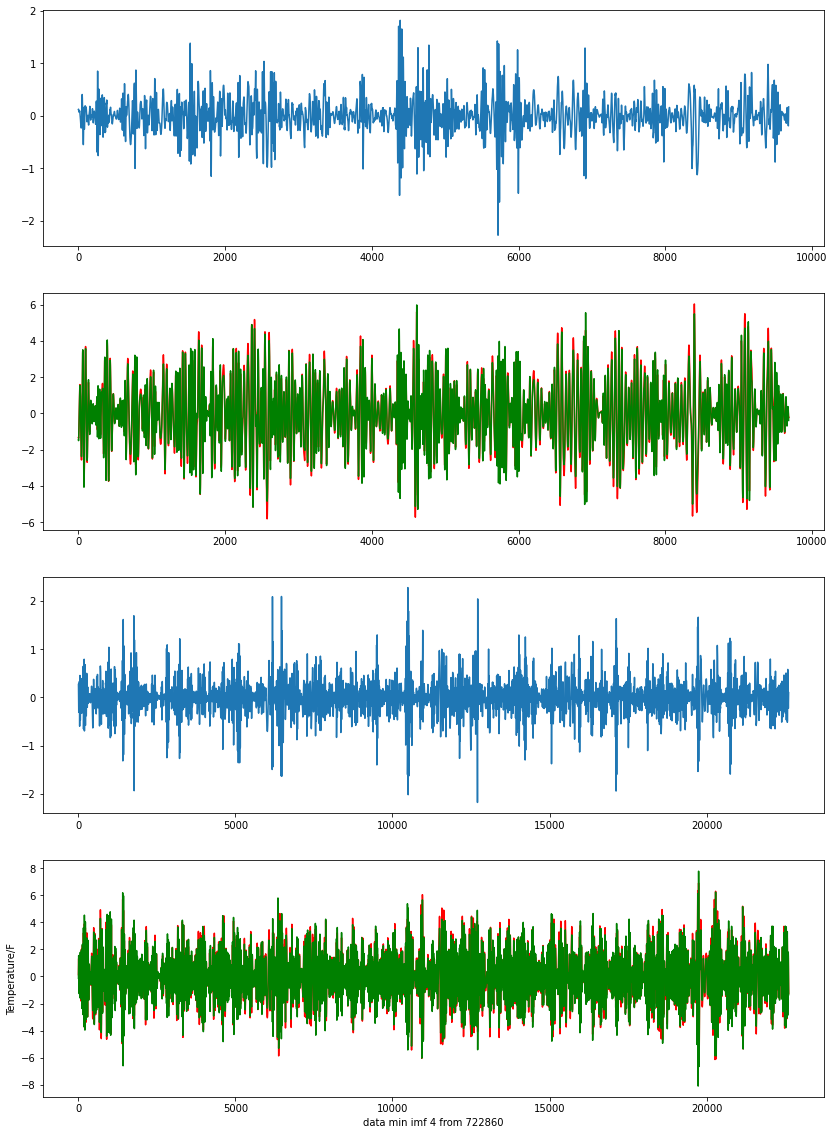

Epoch:10
MSE
TRAIN:0.10481426579794811	TEST:0.09844317663787354
Base_line:0.6154088489216128	DIFFERENT:0.5169656722837394
TARGET:0.061540884892161286
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf4.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________


707/707 [==============================] - 1s 803us/step - loss: 0.2172
Epoch 81/100
707/707 [==============================] - 1s 894us/step - loss: 0.2243
Epoch 82/100
707/707 [==============================] - 1s 737us/step - loss: 0.2195
Epoch 83/100
707/707 [==============================] - 1s 737us/step - loss: 0.2199
Epoch 84/100
707/707 [==============================] - 1s 837us/step - loss: 0.2190
Epoch 85/100
707/707 [==============================] - 1s 866us/step - loss: 0.2183
Epoch 86/100
707/707 [==============================] - 1s 792us/step - loss: 0.2139
Epoch 87/100
707/707 [==============================] - 1s 829us/step - loss: 0.2105
Epoch 88/100
707/707 [==============================] - 1s 969us/step - loss: 0.2158
Epoch 89/100
707/707 [==============================] - 1s 775us/step - loss: 0.2052
Epoch 90/100
707/707 [==============================] - 1s 853us/step - loss: 0.2079
Epoch 91/100
707/707 [==============================] - 1s 890us/step - loss: 

707/707 [==============================] - 1s 997us/step - loss: 0.1600
Epoch 21/25
707/707 [==============================] - 1s 990us/step - loss: 0.1660
Epoch 22/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1607
Epoch 23/25
707/707 [==============================] - 1s 960us/step - loss: 0.1595
Epoch 24/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1625A: 0s - l
Epoch 25/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1608
Epoch:4
MSE
TRAIN:0.016702645662135397	TEST:0.014965259483642804
Base_line:0.1259025759678466	DIFFERENT:0.1109373164842038
TARGET:0.01398917510753851
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 772us/step - loss: 0.1576
Epoch 2/25
707/707 [==============================] - 1s 775us/step - loss: 0.1560
Epoch 3/25
707/707 [==============================] - 1s 804us/step - loss: 0.1569
Epoch 4/25
707/707 [==============================] - 1s 783us/step - loss: 0.1569
Epoch 5/25
707

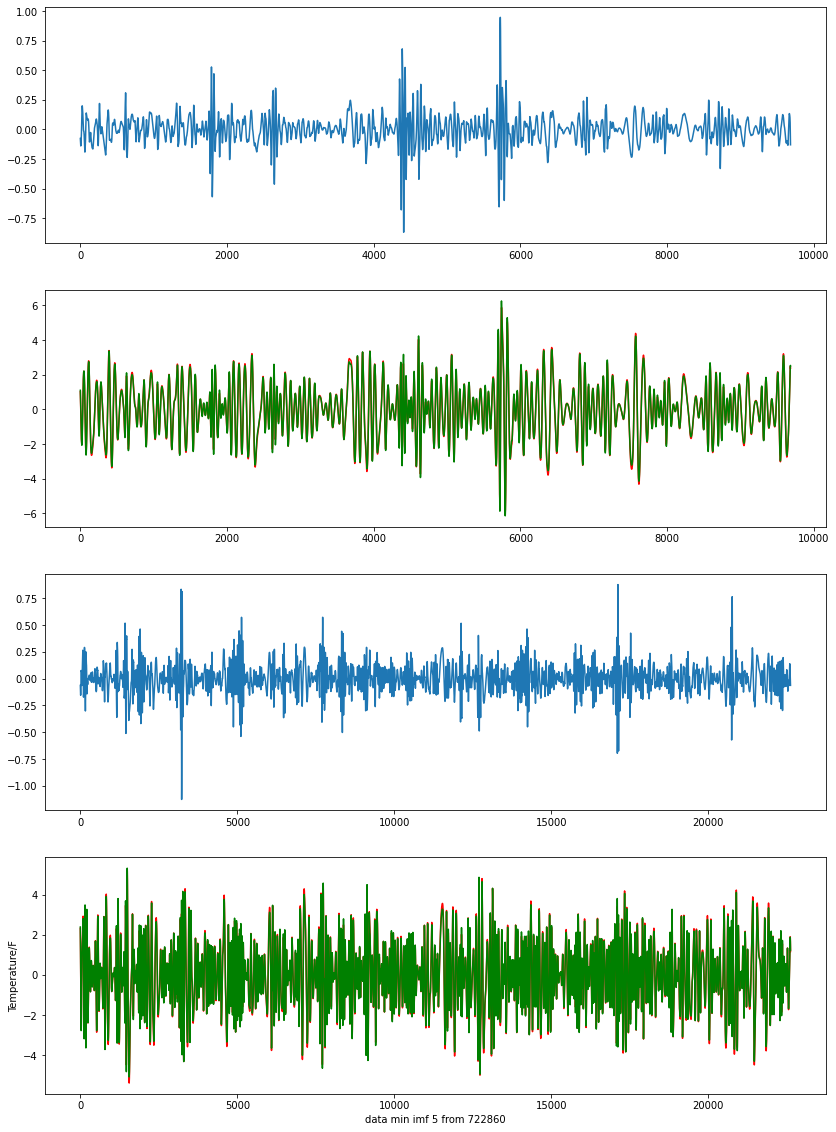

Epoch:5
MSE
TRAIN:0.015119692361736159	TEST:0.013474350044295067
Base_line:0.1259025759678466	DIFFERENT:0.11242822592355153
TARGET:0.01398917510753851
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf5.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________

707/707 [==============================] - 1s 775us/step - loss: 0.6389
Epoch 81/100
707/707 [==============================] - 1s 763us/step - loss: 0.6143
Epoch 82/100
707/707 [==============================] - 0s 696us/step - loss: 0.6214
Epoch 83/100
707/707 [==============================] - 1s 707us/step - loss: 0.6134
Epoch 84/100
707/707 [==============================] - 1s 716us/step - loss: 0.5979
Epoch 85/100
707/707 [==============================] - 0s 702us/step - loss: 0.5963
Epoch 86/100
707/707 [==============================] - 0s 686us/step - loss: 0.6012
Epoch 87/100
707/707 [==============================] - 0s 658us/step - loss: 0.6041
Epoch 88/100
707/707 [==============================] - 0s 659us/step - loss: 0.5795
Epoch 89/100
707/707 [==============================] - 0s 663us/step - loss: 0.5818
Epoch 90/100
707/707 [==============================] - 1s 823us/step - loss: 0.5738
Epoch 91/100
707/707 [==============================] - 1s 840us/step - loss: 

707/707 [==============================] - 1s 978us/step - loss: 0.3298
Epoch 21/25
707/707 [==============================] - 1s 851us/step - loss: 0.3234
Epoch 22/25
707/707 [==============================] - 1s 802us/step - loss: 0.3189
Epoch 23/25
707/707 [==============================] - 1s 899us/step - loss: 0.3188
Epoch 24/25
707/707 [==============================] - 1s 936us/step - loss: 0.3136
Epoch 25/25
707/707 [==============================] - 1s 909us/step - loss: 0.3204
Epoch:4
MSE
TRAIN:0.08224150036321062	TEST:0.09617829141185891
Base_line:0.12534911656144587	DIFFERENT:0.029170825149586965
TARGET:0.015668639570180734
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 819us/step - loss: 0.3082
Epoch 2/25
707/707 [==============================] - 1s 753us/step - loss: 0.3137
Epoch 3/25
707/707 [==============================] - 1s 749us/step - loss: 0.3155
Epoch 4/25
707/707 [==============================] - 0s 692us/step - loss: 0.3132
Epoch 5/25
707/

707/707 [==============================] - 1s 813us/step - loss: 0.2161
Epoch 11/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2223
Epoch 12/25
707/707 [==============================] - 1s 807us/step - loss: 0.2192
Epoch 13/25
707/707 [==============================] - 1s 807us/step - loss: 0.2234
Epoch 14/25
707/707 [==============================] - 1s 847us/step - loss: 0.2176
Epoch 15/25
707/707 [==============================] - 1s 922us/step - loss: 0.2113
Epoch 16/25
707/707 [==============================] - 1s 849us/step - loss: 0.2144
Epoch 17/25
707/707 [==============================] - 1s 758us/step - loss: 0.2184
Epoch 18/25
707/707 [==============================] - 1s 823us/step - loss: 0.2206
Epoch 19/25
707/707 [==============================] - 1s 839us/step - loss: 0.2127
Epoch 20/25
707/707 [==============================] - 1s 839us/step - loss: 0.2161
Epoch 21/25
707/707 [==============================] - 1s 817us/step - loss: 0.2196
Epoch 

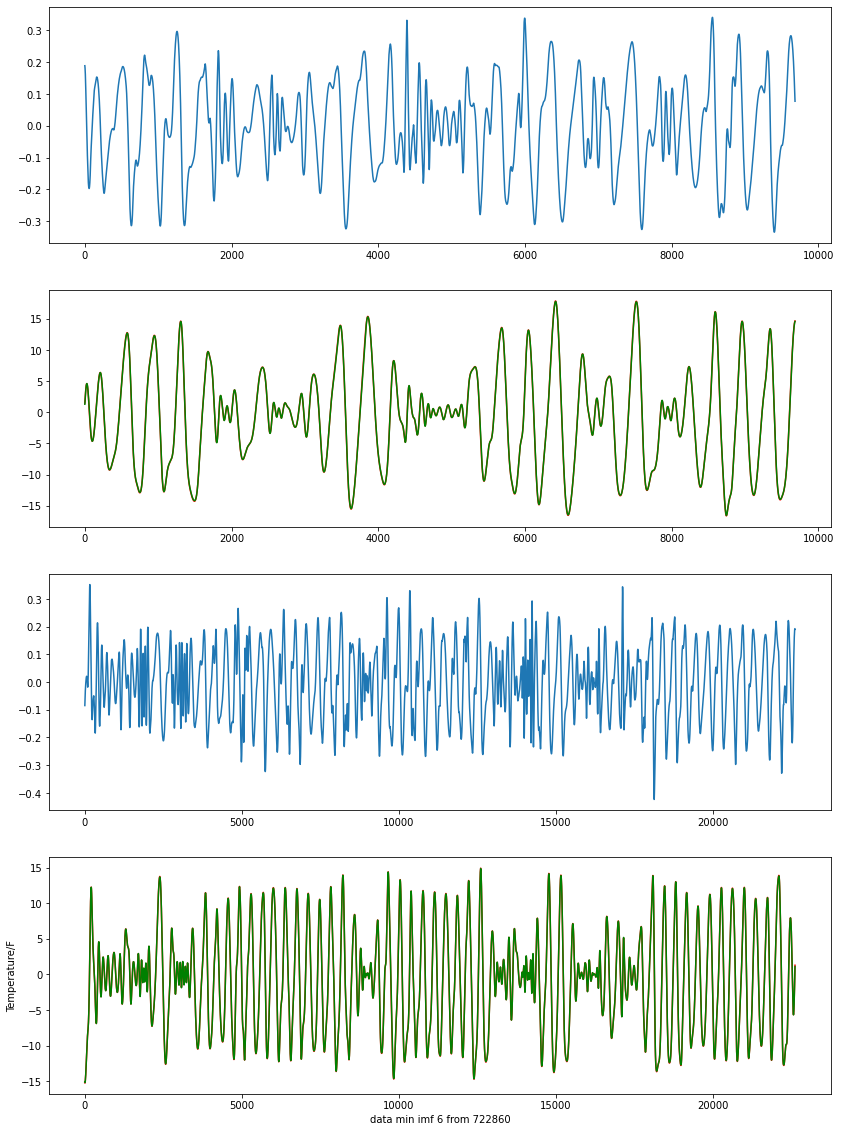

Epoch:10
MSE
TRAIN:0.01753625750306213	TEST:0.020618864057897323
Base_line:0.12534911656144587	DIFFERENT:0.10473025250354855
TARGET:0.015668639570180734
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf6.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________________________________

707/707 [==============================] - 1s 1ms/step - loss: 0.4738
Epoch 81/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4612
Epoch 82/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4665
Epoch 83/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4848
Epoch 84/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4589
Epoch 85/100
707/707 [==============================] - 1s 889us/step - loss: 0.4788
Epoch 86/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4547
Epoch 87/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4554
Epoch 88/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4601
Epoch 89/100
707/707 [==============================] - 1s 1ms/step - loss: 0.4485
Epoch 90/100
707/707 [==============================] - 1s 964us/step - loss: 0.4509
Epoch 91/100
707/707 [==============================] - 1s 947us/step - loss: 0.4506
Epoch 92/10

Epoch 21/25
707/707 [==============================] - 1s 842us/step - loss: 0.3015
Epoch 22/25
707/707 [==============================] - 1s 951us/step - loss: 0.2960
Epoch 23/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2993
Epoch 24/25
707/707 [==============================] - 1s 953us/step - loss: 0.2964
Epoch 25/25
707/707 [==============================] - 1s 933us/step - loss: 0.2891
Epoch:4
MSE
TRAIN:0.10133055399435632	TEST:0.11991232002461163
Base_line:0.03364256885473868	DIFFERENT:0.08626975116987295
TARGET:0.004806081264962668
重新训练25次
Epoch 1/25
707/707 [==============================] - 0s 705us/step - loss: 0.2894
Epoch 2/25
707/707 [==============================] - 1s 967us/step - loss: 0.2894
Epoch 3/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2887
Epoch 4/25
707/707 [==============================] - 1s 843us/step - loss: 0.2934
Epoch 5/25
707/707 [==============================] - 1s 946us/step - loss: 0.2815
Epoch 6/2

707/707 [==============================] - 0s 693us/step - loss: 0.2175
Epoch 11/25
707/707 [==============================] - 1s 719us/step - loss: 0.2179
Epoch 12/25
707/707 [==============================] - 1s 757us/step - loss: 0.2203
Epoch 13/25
707/707 [==============================] - 1s 720us/step - loss: 0.2203
Epoch 14/25
707/707 [==============================] - 1s 727us/step - loss: 0.2200
Epoch 15/25
707/707 [==============================] - 1s 717us/step - loss: 0.2115
Epoch 16/25
707/707 [==============================] - 0s 701us/step - loss: 0.2184
Epoch 17/25
707/707 [==============================] - 0s 703us/step - loss: 0.2150
Epoch 18/25
707/707 [==============================] - 1s 725us/step - loss: 0.2137
Epoch 19/25
707/707 [==============================] - 1s 711us/step - loss: 0.2116
Epoch 20/25
707/707 [==============================] - 0s 690us/step - loss: 0.2133
Epoch 21/25
707/707 [==============================] - 1s 747us/step - loss: 0.2103
Epoc

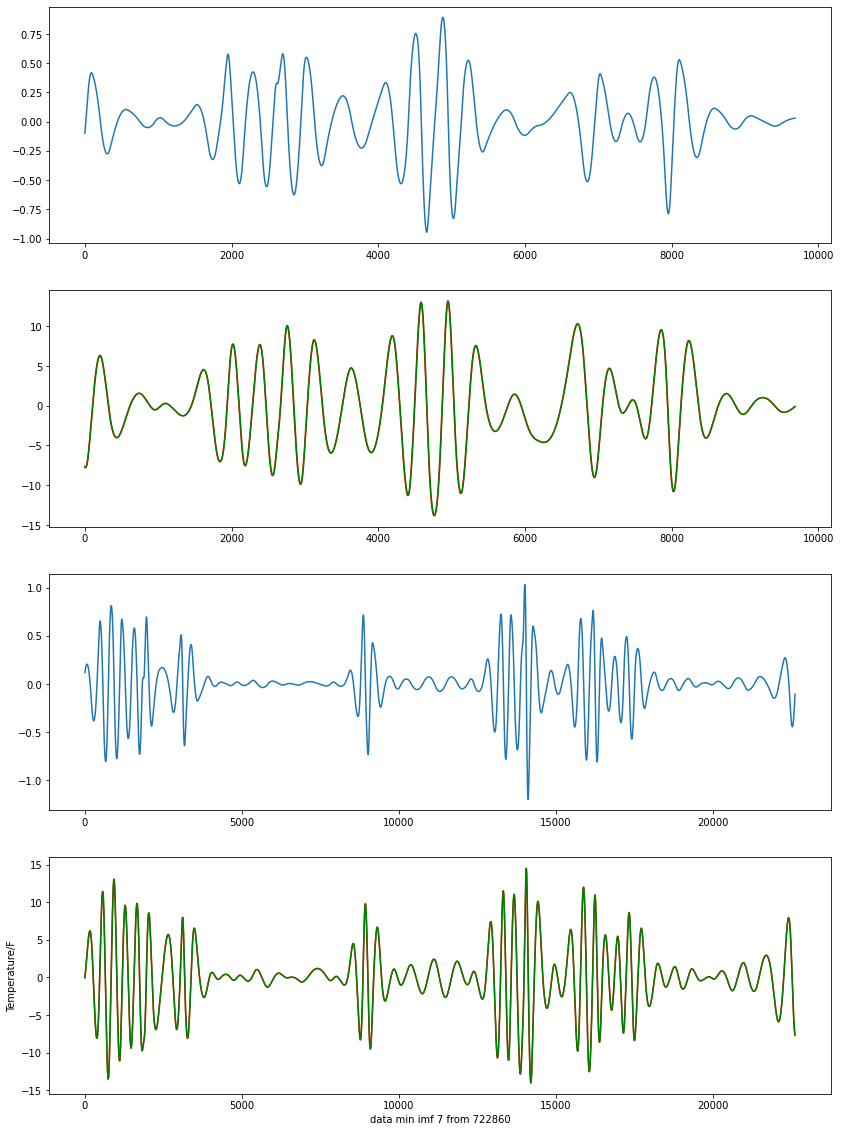

Epoch:10
MSE
TRAIN:0.06651369826091968	TEST:0.07870149334857637
Base_line:0.03364256885473868	DIFFERENT:0.04505892449383769
TARGET:0.004806081264962668
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf7.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
________________________________________________________________

707/707 [==============================] - 1s 802us/step - loss: 0.0529
Epoch 81/100
707/707 [==============================] - 1s 850us/step - loss: 0.0523
Epoch 82/100
707/707 [==============================] - 1s 732us/step - loss: 0.0515
Epoch 83/100
707/707 [==============================] - 1s 732us/step - loss: 0.0511
Epoch 84/100
707/707 [==============================] - 0s 689us/step - loss: 0.0524
Epoch 85/100
707/707 [==============================] - 1s 894us/step - loss: 0.0501
Epoch 86/100
707/707 [==============================] - 1s 896us/step - loss: 0.0501
Epoch 87/100
707/707 [==============================] - 1s 853us/step - loss: 0.0500
Epoch 88/100
707/707 [==============================] - 1s 744us/step - loss: 0.0507
Epoch 89/100
707/707 [==============================] - 1s 767us/step - loss: 0.0501
Epoch 90/100
707/707 [==============================] - 1s 729us/step - loss: 0.0496
Epoch 91/100
707/707 [==============================] - 1s 780us/step - loss: 

707/707 [==============================] - 1s 1ms/step - loss: 0.0471
Epoch 21/25
707/707 [==============================] - 1s 912us/step - loss: 0.0448
Epoch 22/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0469
Epoch 23/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0467A: 0s - loss
Epoch 24/25
707/707 [==============================] - 1s 860us/step - loss: 0.0473
Epoch 25/25
707/707 [==============================] - 1s 903us/step - loss: 0.0446
Epoch:4
MSE
TRAIN:0.0008722742813867241	TEST:0.0024905611428544337
Base_line:0.00029718301369724865	DIFFERENT:0.002193378129157185
TARGET:4.953050228287477e-05
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 976us/step - loss: 0.0449
Epoch 2/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0475
Epoch 3/25
707/707 [==============================] - 1s 854us/step - loss: 0.0458
Epoch 4/25
707/707 [==============================] - 1s 863us/step - loss: 0.0448
Epo

707/707 [==============================] - 1s 735us/step - loss: 0.0421
Epoch 10/25
707/707 [==============================] - 1s 815us/step - loss: 0.0429
Epoch 11/25
707/707 [==============================] - 1s 897us/step - loss: 0.0427
Epoch 12/25
707/707 [==============================] - 1s 896us/step - loss: 0.0430
Epoch 13/25
707/707 [==============================] - 1s 811us/step - loss: 0.0417 0s - loss: 
Epoch 14/25
707/707 [==============================] - 1s 719us/step - loss: 0.0422
Epoch 15/25
707/707 [==============================] - 1s 731us/step - loss: 0.0411
Epoch 16/25
707/707 [==============================] - 1s 770us/step - loss: 0.0437
Epoch 17/25
707/707 [==============================] - 1s 740us/step - loss: 0.0432
Epoch 18/25
707/707 [==============================] - 1s 826us/step - loss: 0.0421
Epoch 19/25
707/707 [==============================] - 1s 883us/step - loss: 0.0432
Epoch 20/25
707/707 [==============================] - 1s 934us/step - loss:

707/707 [==============================] - 1s 972us/step - loss: 0.0390
Epoch 25/25
707/707 [==============================] - 1s 912us/step - loss: 0.0394


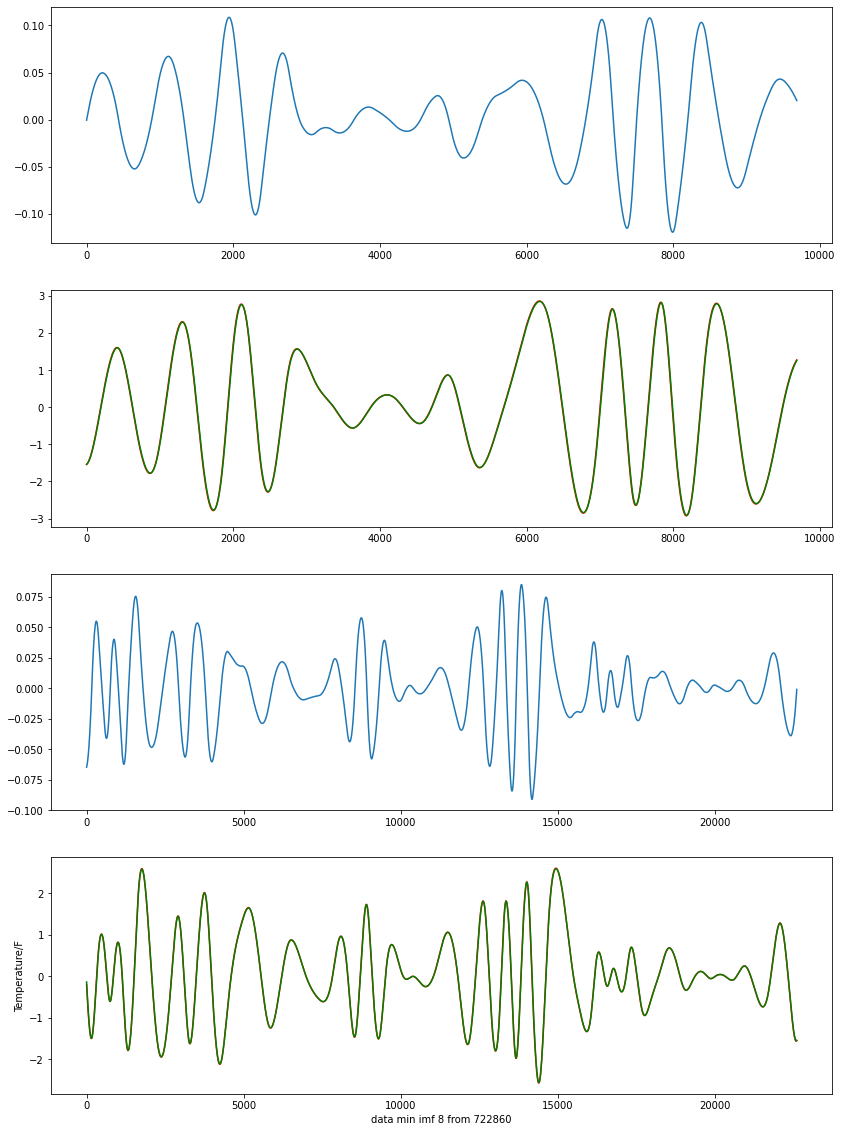

Epoch:10
MSE
TRAIN:0.0008669722126993856	TEST:0.0024789481309576617
Base_line:0.00029718301369724865	DIFFERENT:0.002181765117260413
TARGET:4.953050228287477e-05
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf8.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________________________

707/707 [==============================] - 0s 702us/step - loss: 0.1057
Epoch 81/100
707/707 [==============================] - 0s 697us/step - loss: 0.1053
Epoch 82/100
707/707 [==============================] - 0s 678us/step - loss: 0.1078
Epoch 83/100
707/707 [==============================] - 1s 726us/step - loss: 0.1029
Epoch 84/100
707/707 [==============================] - 1s 721us/step - loss: 0.1066
Epoch 85/100
707/707 [==============================] - 1s 715us/step - loss: 0.1048
Epoch 86/100
707/707 [==============================] - 1s 845us/step - loss: 0.1094
Epoch 87/100
707/707 [==============================] - 1s 842us/step - loss: 0.1009
Epoch 88/100
707/707 [==============================] - 1s 823us/step - loss: 0.1037
Epoch 89/100
707/707 [==============================] - 1s 768us/step - loss: 0.1055
Epoch 90/100
707/707 [==============================] - 1s 859us/step - loss: 0.1042
Epoch 91/100
707/707 [==============================] - 1s 832us/step - loss: 

707/707 [==============================] - 0s 696us/step - loss: 0.0909
Epoch 21/25
707/707 [==============================] - 0s 689us/step - loss: 0.0893
Epoch 22/25
707/707 [==============================] - 0s 702us/step - loss: 0.0877
Epoch 23/25
707/707 [==============================] - 1s 710us/step - loss: 0.0884
Epoch 24/25
707/707 [==============================] - 1s 750us/step - loss: 0.0905
Epoch 25/25
707/707 [==============================] - 1s 756us/step - loss: 0.0894
Epoch:4
MSE
TRAIN:0.00026268171390143657	TEST:0.0001032167724271109
Base_line:6.502773296290668e-05	DIFFERENT:3.8189039464204226e-05
TARGET:1.3005546592581335e-05
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 829us/step - loss: 0.0867
Epoch 2/25
707/707 [==============================] - 1s 766us/step - loss: 0.0881
Epoch 3/25
707/707 [==============================] - 1s 759us/step - loss: 0.0895
Epoch 4/25
707/707 [==============================] - 1s 827us/step - loss: 0.0892 0s -

Epoch 9/25
707/707 [==============================] - 1s 738us/step - loss: 0.0788
Epoch 10/25
707/707 [==============================] - 1s 750us/step - loss: 0.0769
Epoch 11/25
707/707 [==============================] - 1s 707us/step - loss: 0.0783
Epoch 12/25
707/707 [==============================] - 0s 678us/step - loss: 0.0768
Epoch 13/25
707/707 [==============================] - 1s 731us/step - loss: 0.0761
Epoch 14/25
707/707 [==============================] - 0s 684us/step - loss: 0.0781
Epoch 15/25
707/707 [==============================] - 1s 742us/step - loss: 0.0761
Epoch 16/25
707/707 [==============================] - 0s 691us/step - loss: 0.0756
Epoch 17/25
707/707 [==============================] - 0s 704us/step - loss: 0.0748
Epoch 18/25
707/707 [==============================] - 1s 715us/step - loss: 0.0753
Epoch 19/25
707/707 [==============================] - 1s 750us/step - loss: 0.0747
Epoch 20/25
707/707 [==============================] - 1s 764us/step - loss: 

707/707 [==============================] - 0s 697us/step - loss: 0.0692


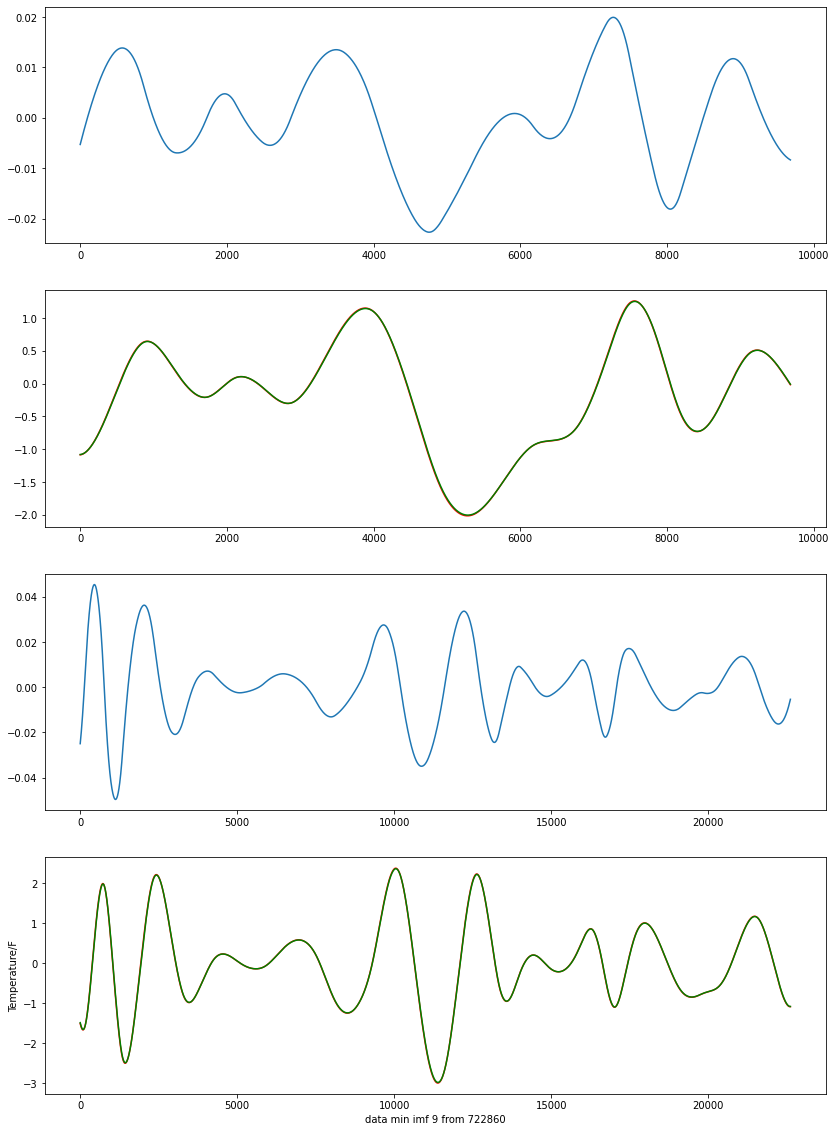

Epoch:10
MSE
TRAIN:0.00025685172205453964	TEST:0.00010025503606188752
Base_line:6.502773296290668e-05	DIFFERENT:3.5227303098980844e-05
TARGET:1.3005546592581335e-05
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf9.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
___________________________________________________

707/707 [==============================] - 1s 907us/step - loss: 0.0845
Epoch 81/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0838
Epoch 82/100
707/707 [==============================] - 1s 996us/step - loss: 0.0840
Epoch 83/100
707/707 [==============================] - 1s 801us/step - loss: 0.0865
Epoch 84/100
707/707 [==============================] - 1s 841us/step - loss: 0.0883
Epoch 85/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0863
Epoch 86/100
707/707 [==============================] - 1s 737us/step - loss: 0.0842
Epoch 87/100
707/707 [==============================] - 1s 733us/step - loss: 0.0885
Epoch 88/100
707/707 [==============================] - 1s 979us/step - loss: 0.0834
Epoch 89/100
707/707 [==============================] - 1s 843us/step - loss: 0.0878
Epoch 90/100
707/707 [==============================] - 1s 911us/step - loss: 0.0876
Epoch 91/100
707/707 [==============================] - 1s 861us/step - loss: 0.08

707/707 [==============================] - 1s 856us/step - loss: 0.0731
Epoch 21/25
707/707 [==============================] - 1s 827us/step - loss: 0.0728
Epoch 22/25
707/707 [==============================] - 1s 881us/step - loss: 0.0720
Epoch 23/25
707/707 [==============================] - 1s 901us/step - loss: 0.0734
Epoch 24/25
707/707 [==============================] - 1s 870us/step - loss: 0.0720
Epoch 25/25
707/707 [==============================] - 1s 980us/step - loss: 0.0709
Epoch:4
MSE
TRAIN:0.00011089615602394216	TEST:9.817555080393277e-06
Base_line:1.21443306707013e-05	DIFFERENT:2.3267755903080228e-06
TARGET:3.036082667675325e-06
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 888us/step - loss: 0.0718
Epoch 2/25
707/707 [==============================] - 1s 838us/step - loss: 0.0721
Epoch 3/25
707/707 [==============================] - 1s 859us/step - loss: 0.0722
Epoch 4/25
707/707 [==============================] - 1s 798us/step - loss: 0.0718
Epoch 

707/707 [==============================] - 1s 740us/step - loss: 0.0613
Epoch 10/25
707/707 [==============================] - 1s 752us/step - loss: 0.0602
Epoch 11/25
707/707 [==============================] - 1s 735us/step - loss: 0.0614
Epoch 12/25
707/707 [==============================] - 1s 784us/step - loss: 0.0621
Epoch 13/25
707/707 [==============================] - 1s 738us/step - loss: 0.0601
Epoch 14/25
707/707 [==============================] - 1s 754us/step - loss: 0.0600
Epoch 15/25
707/707 [==============================] - 1s 781us/step - loss: 0.0607
Epoch 16/25
707/707 [==============================] - 1s 773us/step - loss: 0.0610
Epoch 17/25
707/707 [==============================] - 1s 794us/step - loss: 0.0602
Epoch 18/25
707/707 [==============================] - 1s 743us/step - loss: 0.0615
Epoch 19/25
707/707 [==============================] - 1s 736us/step - loss: 0.0603
Epoch 20/25
707/707 [==============================] - 1s 749us/step - loss: 0.0615
Epoc

707/707 [==============================] - 1s 810us/step - loss: 0.0534


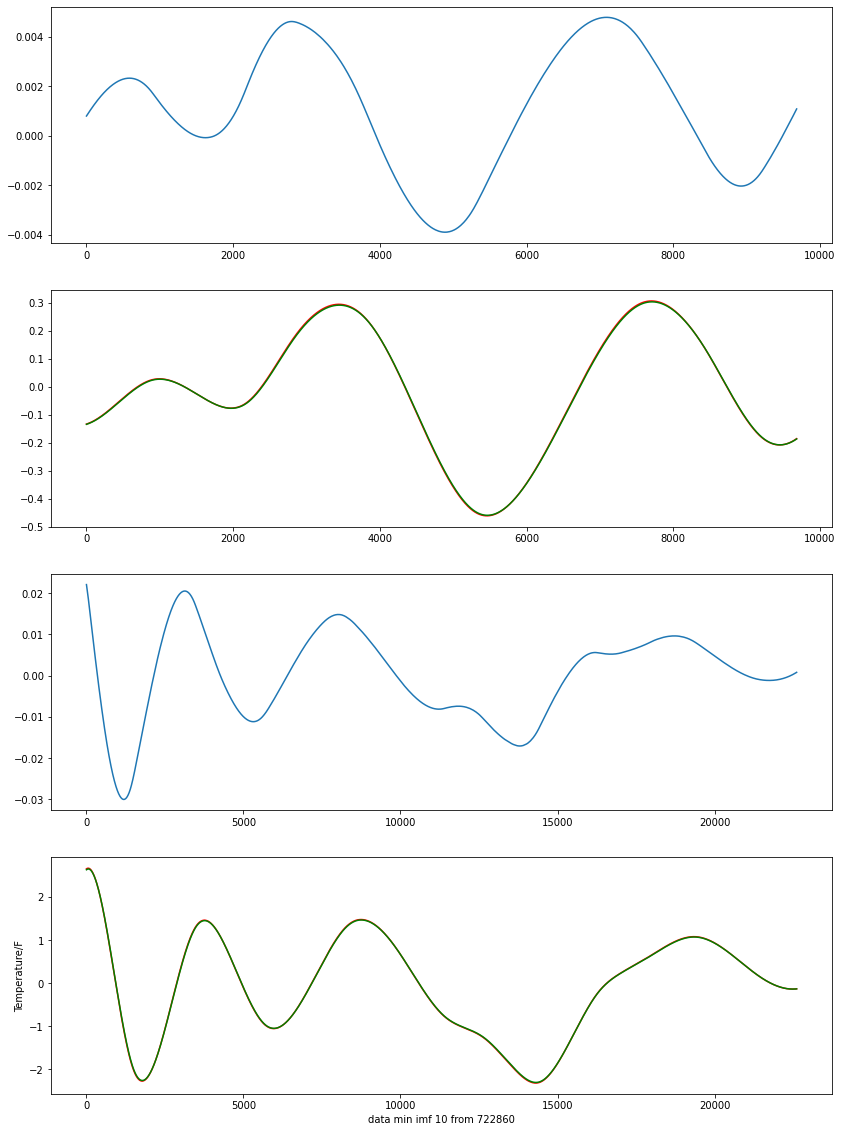

Epoch:10
MSE
TRAIN:0.00011146843282702143	TEST:7.259172209885699e-06
Base_line:1.21443306707013e-05	DIFFERENT:4.8851584608156e-06
TARGET:3.036082667675325e-06
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf10.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
________________________________________________________

707/707 [==============================] - 1s 748us/step - loss: 0.0588
Epoch 80/100
707/707 [==============================] - 1s 794us/step - loss: 0.0615
Epoch 81/100
707/707 [==============================] - 1s 809us/step - loss: 0.0592
Epoch 82/100
707/707 [==============================] - 1s 792us/step - loss: 0.0597
Epoch 83/100
707/707 [==============================] - 1s 742us/step - loss: 0.0602
Epoch 84/100
707/707 [==============================] - 1s 735us/step - loss: 0.0601
Epoch 85/100
707/707 [==============================] - 1s 752us/step - loss: 0.0606
Epoch 86/100
707/707 [==============================] - 1s 764us/step - loss: 0.0604
Epoch 87/100
707/707 [==============================] - 1s 718us/step - loss: 0.0576
Epoch 88/100
707/707 [==============================] - 1s 725us/step - loss: 0.0589
Epoch 89/100
707/707 [==============================] - 1s 771us/step - loss: 0.0607
Epoch 90/100
707/707 [==============================] - 1s 773us/step - loss: 

707/707 [==============================] - 1s 870us/step - loss: 0.0562
Epoch 20/25
707/707 [==============================] - 1s 847us/step - loss: 0.0544
Epoch 21/25
707/707 [==============================] - 1s 951us/step - loss: 0.0537
Epoch 22/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0539
Epoch 23/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0556
Epoch 24/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0541
Epoch 25/25
707/707 [==============================] - 1s 908us/step - loss: 0.0535
Epoch:4
MSE
TRAIN:4.0670762509525486e-05	TEST:0.00018084074531028968
Base_line:1.388142168764175e-06	DIFFERENT:0.0001794526031415255
TARGET:4.6271405625472503e-07
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 893us/step - loss: 0.0547
Epoch 2/25
707/707 [==============================] - 1s 720us/step - loss: 0.0549
Epoch 3/25
707/707 [==============================] - 1s 711us/step - loss: 0.0533
Epoch 4/2

707/707 [==============================] - 1s 758us/step - loss: 0.0507
Epoch 9/25
707/707 [==============================] - 1s 935us/step - loss: 0.0503
Epoch 10/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0493
Epoch 11/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0516
Epoch 12/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0506
Epoch 13/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0486
Epoch 14/25
707/707 [==============================] - 1s 881us/step - loss: 0.0494
Epoch 15/25
707/707 [==============================] - 1s 952us/step - loss: 0.0487
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0480
Epoch 17/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0495
Epoch 18/25
707/707 [==============================] - 1s 910us/step - loss: 0.0498
Epoch 19/25
707/707 [==============================] - 1s 946us/step - loss: 0.0489
Epoch 20/25
707/7

707/707 [==============================] - 1s 795us/step - loss: 0.0468
Epoch 25/25
707/707 [==============================] - 1s 767us/step - loss: 0.0454


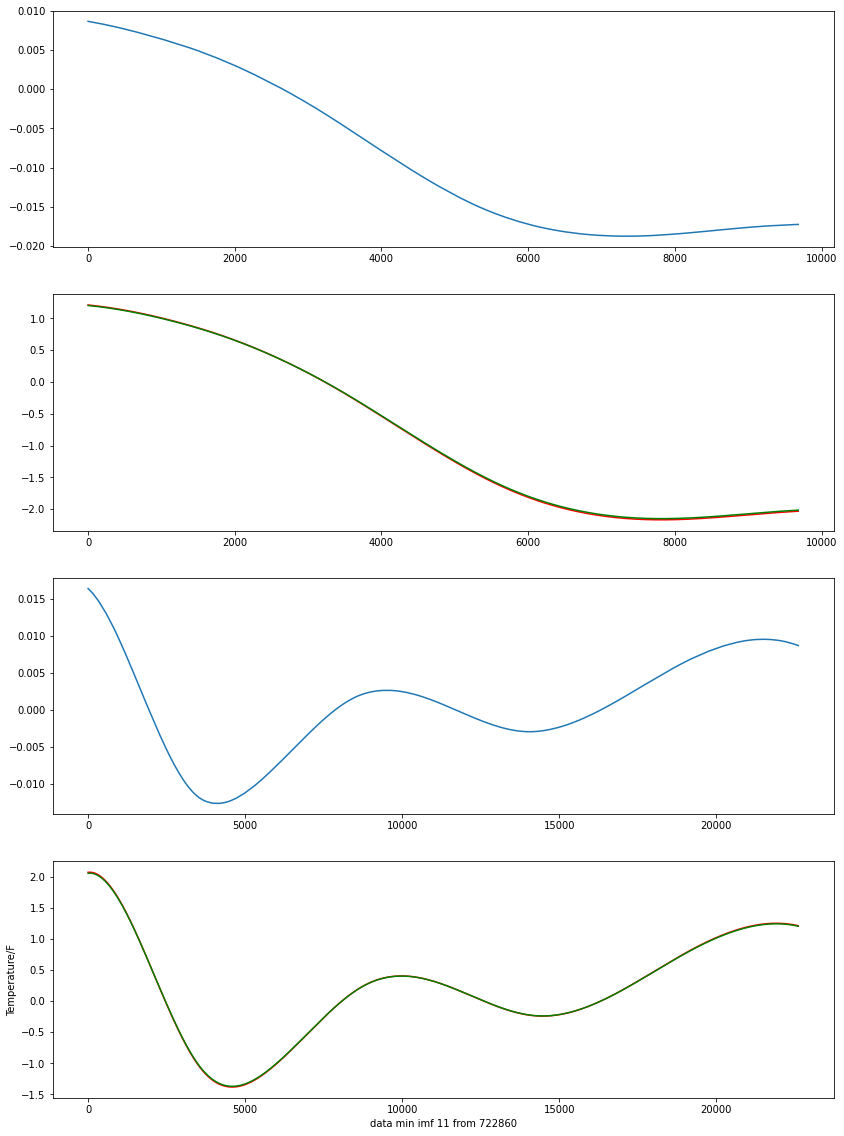

Epoch:10
MSE
TRAIN:4.405085453544914e-05	TEST:0.00017417894153166577
Base_line:1.388142168764175e-06	DIFFERENT:0.00017279079936290159
TARGET:4.6271405625472503e-07
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf11.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
___________________________________________________

707/707 [==============================] - 1s 752us/step - loss: 4.9690
Epoch 81/100
707/707 [==============================] - 1s 722us/step - loss: 5.1430
Epoch 82/100
707/707 [==============================] - 1s 749us/step - loss: 5.0108
Epoch 83/100
707/707 [==============================] - 1s 748us/step - loss: 5.0110
Epoch 84/100
707/707 [==============================] - 1s 794us/step - loss: 4.9612
Epoch 85/100
707/707 [==============================] - 1s 826us/step - loss: 5.1405
Epoch 86/100
707/707 [==============================] - 1s 791us/step - loss: 5.0920
Epoch 87/100
707/707 [==============================] - 1s 747us/step - loss: 5.0931
Epoch 88/100
707/707 [==============================] - 1s 753us/step - loss: 5.0516
Epoch 89/100
707/707 [==============================] - 1s 756us/step - loss: 5.0705
Epoch 90/100
707/707 [==============================] - 1s 776us/step - loss: 5.0877
Epoch 91/100
707/707 [==============================] - 1s 730us/step - loss: 

707/707 [==============================] - 1s 827us/step - loss: 5.0480
Epoch 21/25
707/707 [==============================] - 1s 841us/step - loss: 5.0533
Epoch 22/25
707/707 [==============================] - 1s 932us/step - loss: 5.0173
Epoch 23/25
707/707 [==============================] - 1s 866us/step - loss: 5.0833
Epoch 24/25
707/707 [==============================] - 1s 937us/step - loss: 5.1748
Epoch 25/25
707/707 [==============================] - 1s 902us/step - loss: 5.0645
Epoch:4
MSE
TRAIN:0.00011591115504422031	TEST:0.0001100546054658139
Base_line:1.8697955100522078e-07	DIFFERENT:0.00010986762591480868
TARGET:9.348977550261039e-08
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 821us/step - loss: 5.0815
Epoch 2/25
707/707 [==============================] - 1s 890us/step - loss: 4.9904
Epoch 3/25
707/707 [==============================] - 1s 828us/step - loss: 4.9486
Epoch 4/25
707/707 [==============================] - 1s 917us/step - loss: 5.0833
Epoc

707/707 [==============================] - 1s 851us/step - loss: 4.9855
Epoch 10/25
707/707 [==============================] - 1s 800us/step - loss: 5.0014
Epoch 11/25
707/707 [==============================] - 1s 745us/step - loss: 5.0261
Epoch 12/25
707/707 [==============================] - 1s 784us/step - loss: 5.0063
Epoch 13/25
707/707 [==============================] - 1s 1ms/step - loss: 4.9934A: 0s - los
Epoch 14/25
707/707 [==============================] - 1s 1ms/step - loss: 5.0212
Epoch 15/25
707/707 [==============================] - 1s 1ms/step - loss: 4.9971
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 5.0089
Epoch 17/25
707/707 [==============================] - 1s 978us/step - loss: 5.0655
Epoch 18/25
707/707 [==============================] - 1s 921us/step - loss: 4.9787
Epoch 19/25
707/707 [==============================] - 1s 955us/step - loss: 4.9911
Epoch 20/25
707/707 [==============================] - 1s 951us/step - loss: 4.9191
E

707/707 [==============================] - 1s 998us/step - loss: 5.0273


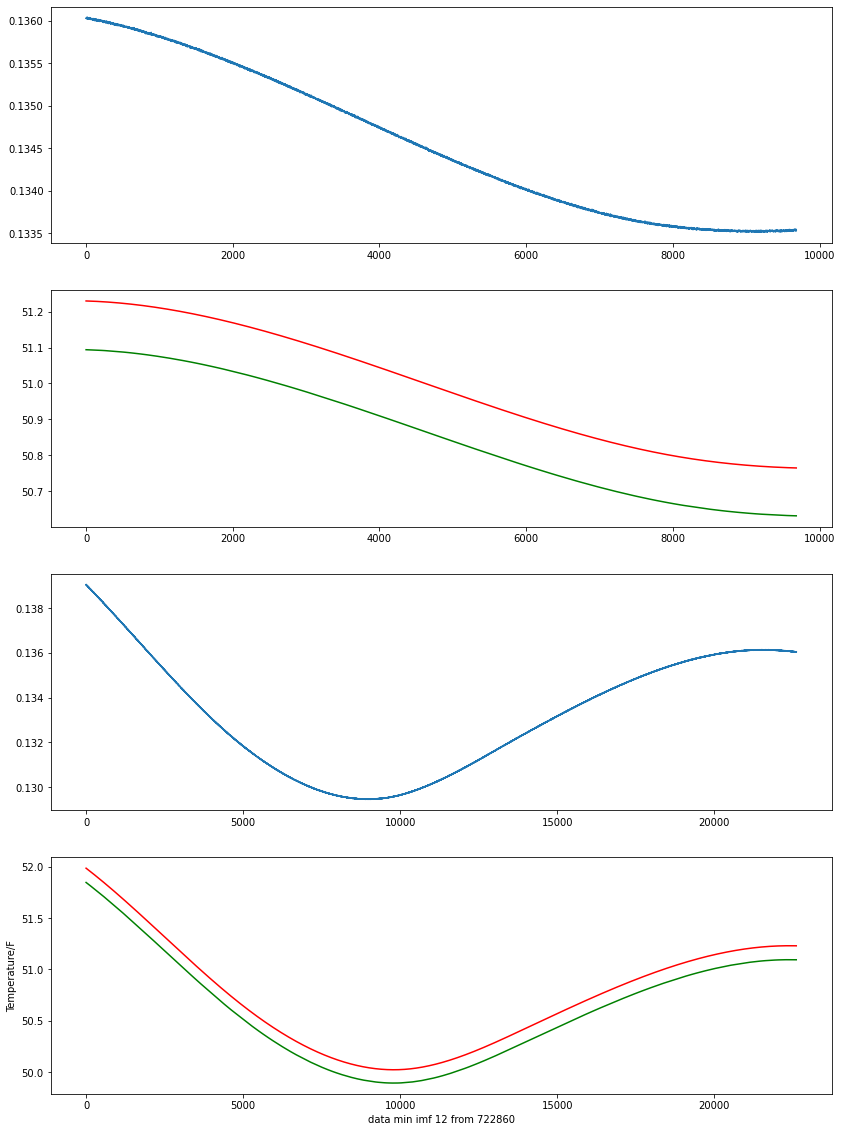

Epoch:10
MSE
TRAIN:0.017757489660493075	TEST:0.018104702736962155
Base_line:1.8697955100522078e-07	DIFFERENT:0.01810451575741115
TARGET:9.348977550261039e-08
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_min_imf12.params/assets
-------------------------------------------------------------------


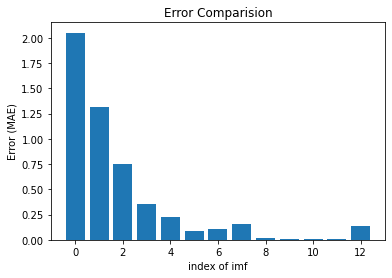

In [18]:
train("min")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
____________________________________________________

707/707 [==============================] - 1s 904us/step - loss: 7.1085
Epoch 84/100
707/707 [==============================] - 1s 991us/step - loss: 7.2756
Epoch 85/100
707/707 [==============================] - 1s 1ms/step - loss: 7.2199
Epoch 86/100
707/707 [==============================] - 1s 825us/step - loss: 7.0808
Epoch 87/100
707/707 [==============================] - 1s 920us/step - loss: 7.2198
Epoch 88/100
707/707 [==============================] - 1s 1ms/step - loss: 7.1468
Epoch 89/100
707/707 [==============================] - 1s 1ms/step - loss: 7.1171
Epoch 90/100
707/707 [==============================] - 1s 793us/step - loss: 7.1915
Epoch 91/100
707/707 [==============================] - 1s 817us/step - loss: 7.1033
Epoch 92/100
707/707 [==============================] - 1s 872us/step - loss: 7.2130
Epoch 93/100
707/707 [==============================] - 1s 818us/step - loss: 7.0319
Epoch 94/100
707/707 [==============================] - 1s 725us/step - loss: 7.1473

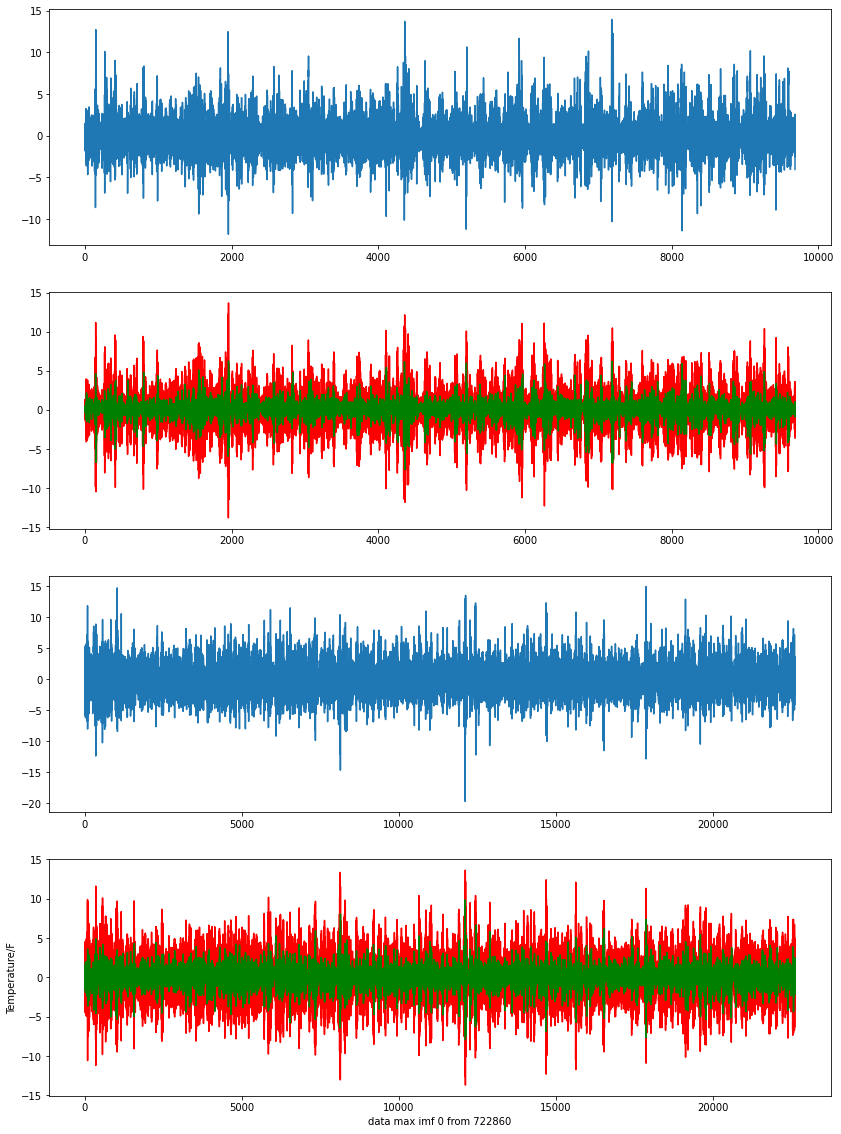

Epoch:0
MSE
TRAIN:6.623584181937741	TEST:6.902803842059687
Base_line:102.22450828973017	DIFFERENT:95.32170444767048
TARGET:7.863423714594628
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf0.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (

707/707 [==============================] - 1s 766us/step - loss: 6.9751
Epoch 81/100
707/707 [==============================] - 1s 766us/step - loss: 7.1734
Epoch 82/100
707/707 [==============================] - 1s 856us/step - loss: 7.3043
Epoch 83/100
707/707 [==============================] - 1s 812us/step - loss: 7.1869
Epoch 84/100
707/707 [==============================] - 1s 750us/step - loss: 7.2365
Epoch 85/100
707/707 [==============================] - 1s 729us/step - loss: 7.0195
Epoch 86/100
707/707 [==============================] - 1s 716us/step - loss: 7.1462
Epoch 87/100
707/707 [==============================] - 1s 834us/step - loss: 6.9449
Epoch 88/100
707/707 [==============================] - 1s 924us/step - loss: 7.1305
Epoch 89/100
707/707 [==============================] - 1s 990us/step - loss: 7.1890
Epoch 90/100
707/707 [==============================] - 1s 814us/step - loss: 7.1496
Epoch 91/100
707/707 [==============================] - 1s 802us/step - loss: 

Epoch 21/25
707/707 [==============================] - 1s 785us/step - loss: 6.6514
Epoch 22/25
707/707 [==============================] - 1s 766us/step - loss: 6.6173
Epoch 23/25
707/707 [==============================] - 1s 822us/step - loss: 6.6237
Epoch 24/25
707/707 [==============================] - 1s 800us/step - loss: 6.5821
Epoch 25/25
707/707 [==============================] - 1s 719us/step - loss: 6.5614
Epoch:4
MSE
TRAIN:6.270673414028109	TEST:6.261893922667413
Base_line:48.99710413407625	DIFFERENT:42.73521021140884
TARGET:4.083092011173021
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 855us/step - loss: 6.6337
Epoch 2/25
707/707 [==============================] - 1s 910us/step - loss: 6.6243
Epoch 3/25
707/707 [==============================] - 1s 765us/step - loss: 6.5693
Epoch 4/25
707/707 [==============================] - 1s 791us/step - loss: 6.6662
Epoch 5/25
707/707 [==============================] - 1s 712us/step - loss: 6.5966
Epoch 6/25
707/7

Epoch 11/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3214
Epoch 12/25
707/707 [==============================] - 1s 819us/step - loss: 6.3659
Epoch 13/25
707/707 [==============================] - 1s 904us/step - loss: 6.3398
Epoch 14/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3389
Epoch 15/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3217
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3615
Epoch 17/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3392
Epoch 18/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3093
Epoch 19/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3458
Epoch 20/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3568
Epoch 21/25
707/707 [==============================] - 1s 1ms/step - loss: 6.3384
Epoch 22/25
707/707 [==============================] - 1s 891us/step - loss: 6.3239
Epoch 23/2

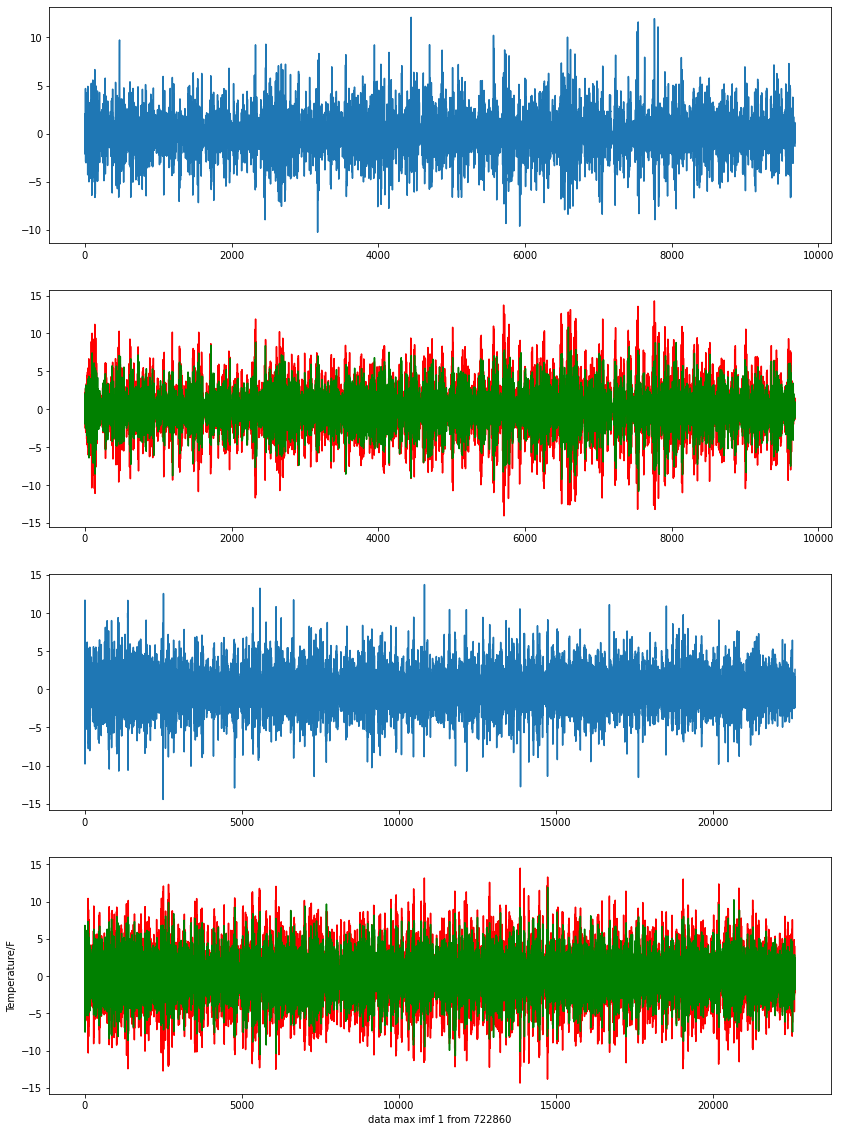

Epoch:10
MSE
TRAIN:5.896815563264103	TEST:5.860692300476069
Base_line:48.99710413407625	DIFFERENT:43.136411833600185
TARGET:4.083092011173021
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf1.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 

707/707 [==============================] - 1s 799us/step - loss: 3.0588
Epoch 81/100
707/707 [==============================] - 1s 832us/step - loss: 3.1096
Epoch 82/100
707/707 [==============================] - 1s 792us/step - loss: 3.0475
Epoch 83/100
707/707 [==============================] - 1s 872us/step - loss: 3.0736
Epoch 84/100
707/707 [==============================] - 1s 740us/step - loss: 2.9893
Epoch 85/100
707/707 [==============================] - 1s 774us/step - loss: 2.9321
Epoch 86/100
707/707 [==============================] - 1s 783us/step - loss: 3.0022
Epoch 87/100
707/707 [==============================] - 1s 846us/step - loss: 2.9020
Epoch 88/100
707/707 [==============================] - 1s 767us/step - loss: 2.9763
Epoch 89/100
707/707 [==============================] - 1s 796us/step - loss: 2.9396
Epoch 90/100
707/707 [==============================] - 1s 772us/step - loss: 2.9401
Epoch 91/100
707/707 [==============================] - 1s 786us/step - loss: 

707/707 [==============================] - 0s 702us/step - loss: 2.1228
Epoch 21/25
707/707 [==============================] - 1s 740us/step - loss: 2.1208
Epoch 22/25
707/707 [==============================] - 1s 737us/step - loss: 2.1025
Epoch 23/25
707/707 [==============================] - 1s 822us/step - loss: 2.0982
Epoch 24/25
707/707 [==============================] - 1s 737us/step - loss: 2.0912
Epoch 25/25
707/707 [==============================] - 1s 779us/step - loss: 2.0804


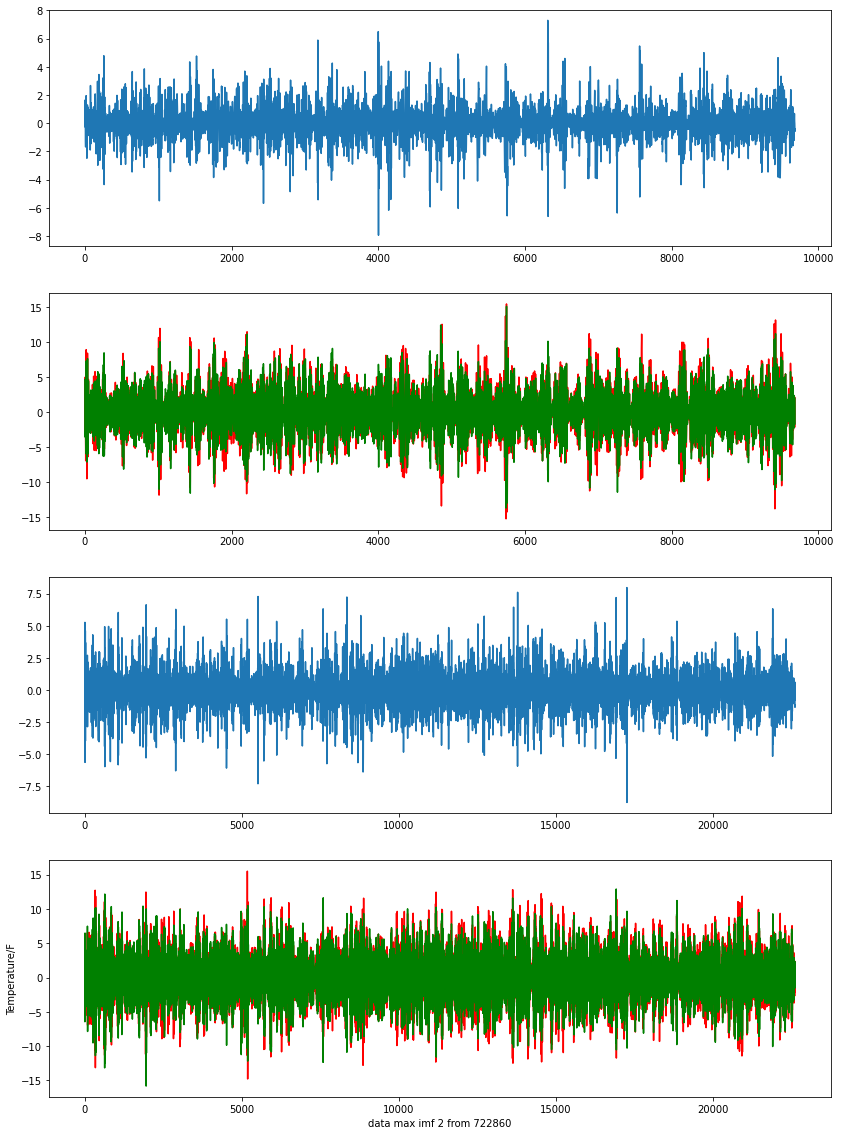

Epoch:3
MSE
TRAIN:1.6733811282711555	TEST:1.54511432709808
Base_line:17.298863256996082	DIFFERENT:15.753748929898002
TARGET:1.5726239324541893
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf2.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2

707/707 [==============================] - 1s 810us/step - loss: 1.1136
Epoch 81/100
707/707 [==============================] - 1s 820us/step - loss: 1.1141
Epoch 82/100
707/707 [==============================] - 1s 869us/step - loss: 1.1357
Epoch 83/100
707/707 [==============================] - 1s 858us/step - loss: 1.1250
Epoch 84/100
707/707 [==============================] - 1s 770us/step - loss: 1.1141
Epoch 85/100
707/707 [==============================] - 1s 872us/step - loss: 1.1025
Epoch 86/100
707/707 [==============================] - 1s 953us/step - loss: 1.0768
Epoch 87/100
707/707 [==============================] - 1s 818us/step - loss: 1.0623
Epoch 88/100
707/707 [==============================] - 1s 817us/step - loss: 1.0512
Epoch 89/100
707/707 [==============================] - 1s 783us/step - loss: 1.0261
Epoch 90/100
707/707 [==============================] - 1s 777us/step - loss: 1.0155
Epoch 91/100
707/707 [==============================] - 1s 764us/step - loss: 

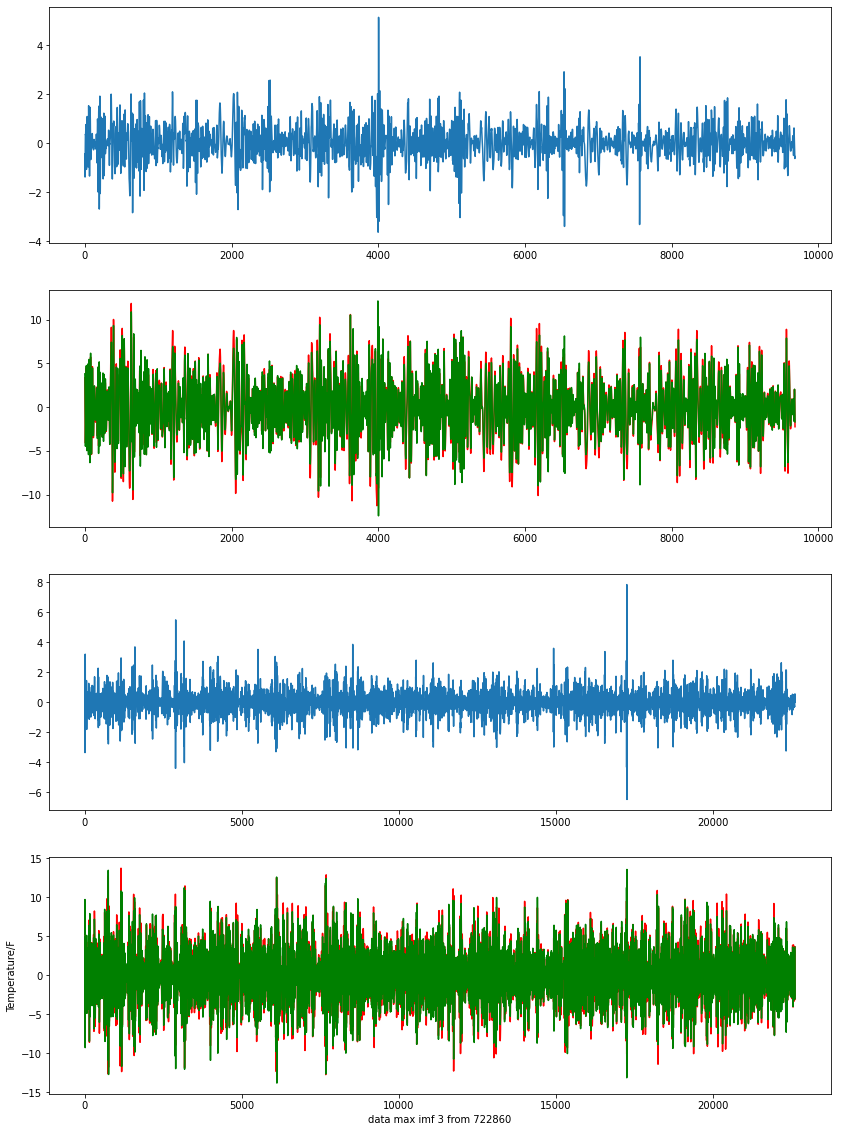

Epoch:0
MSE
TRAIN:0.540665757578119	TEST:0.44448079797046797
Base_line:5.030151924684408	DIFFERENT:4.58567112671394
TARGET:0.5030151924684408
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf3.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 

707/707 [==============================] - 1s 807us/step - loss: 0.4217
Epoch 81/100
707/707 [==============================] - 1s 805us/step - loss: 0.4187
Epoch 82/100
707/707 [==============================] - 1s 736us/step - loss: 0.4231
Epoch 83/100
707/707 [==============================] - 1s 772us/step - loss: 0.4058
Epoch 84/100
707/707 [==============================] - 1s 750us/step - loss: 0.4152
Epoch 85/100
707/707 [==============================] - 1s 796us/step - loss: 0.3982
Epoch 86/100
707/707 [==============================] - 1s 775us/step - loss: 0.4114
Epoch 87/100
707/707 [==============================] - 1s 770us/step - loss: 0.4201
Epoch 88/100
707/707 [==============================] - 1s 778us/step - loss: 0.4003
Epoch 89/100
707/707 [==============================] - 1s 823us/step - loss: 0.4016
Epoch 90/100
707/707 [==============================] - 1s 803us/step - loss: 0.4097
Epoch 91/100
707/707 [==============================] - 1s 724us/step - loss: 

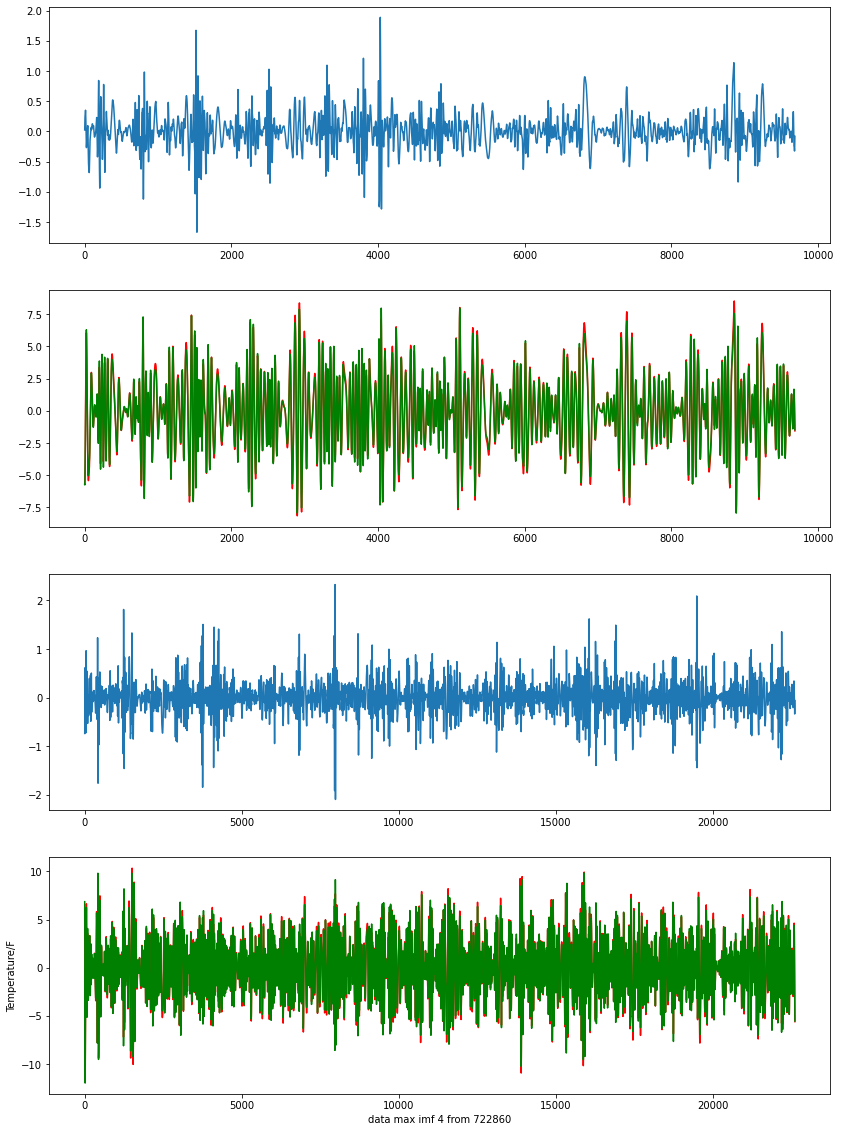

Epoch:0
MSE
TRAIN:0.09927049649970635	TEST:0.07196924413171911
Base_line:0.9654665476227708	DIFFERENT:0.8934973034910517
TARGET:0.10727406084697454
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf4.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
de

707/707 [==============================] - 0s 699us/step - loss: 0.4440
Epoch 81/100
707/707 [==============================] - 1s 755us/step - loss: 0.4355
Epoch 82/100
707/707 [==============================] - 1s 741us/step - loss: 0.4441
Epoch 83/100
707/707 [==============================] - 1s 726us/step - loss: 0.4262
Epoch 84/100
707/707 [==============================] - 1s 750us/step - loss: 0.4096
Epoch 85/100
707/707 [==============================] - 1s 749us/step - loss: 0.4175
Epoch 86/100
707/707 [==============================] - 1s 737us/step - loss: 0.4193
Epoch 87/100
707/707 [==============================] - 1s 744us/step - loss: 0.4039
Epoch 88/100
707/707 [==============================] - 1s 729us/step - loss: 0.4034
Epoch 89/100
707/707 [==============================] - 1s 732us/step - loss: 0.4121
Epoch 90/100
707/707 [==============================] - 1s 756us/step - loss: 0.4063
Epoch 91/100
707/707 [==============================] - 1s 739us/step - loss: 

707/707 [==============================] - 1s 811us/step - loss: 0.2330
Epoch 21/25
707/707 [==============================] - 1s 798us/step - loss: 0.2291
Epoch 22/25
707/707 [==============================] - 1s 755us/step - loss: 0.2271
Epoch 23/25
707/707 [==============================] - 1s 765us/step - loss: 0.2291
Epoch 24/25
707/707 [==============================] - 1s 763us/step - loss: 0.2260
Epoch 25/25
707/707 [==============================] - 1s 775us/step - loss: 0.2285
Epoch:4
MSE
TRAIN:0.032209376802803474	TEST:0.046766117298935046
Base_line:0.15227909792836325	DIFFERENT:0.10551298062942821
TARGET:0.019034887241045406
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 804us/step - loss: 0.2213
Epoch 2/25
707/707 [==============================] - 1s 825us/step - loss: 0.2223
Epoch 3/25
707/707 [==============================] - 1s 794us/step - loss: 0.2213
Epoch 4/25
707/707 [==============================] - 1s 777us/step - loss: 0.2189
Epoch 5/25
707

707/707 [==============================] - 1s 781us/step - loss: 0.1551
Epoch 10/25
707/707 [==============================] - 1s 738us/step - loss: 0.1610
Epoch 11/25
707/707 [==============================] - 1s 735us/step - loss: 0.1557
Epoch 12/25
707/707 [==============================] - 1s 750us/step - loss: 0.1571
Epoch 13/25
707/707 [==============================] - 1s 759us/step - loss: 0.1519
Epoch 14/25
707/707 [==============================] - 1s 951us/step - loss: 0.1553
Epoch 15/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1520
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1588
Epoch 17/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1549
Epoch 18/25
707/707 [==============================] - 1s 768us/step - loss: 0.1541
Epoch 19/25
707/707 [==============================] - 1s 977us/step - loss: 0.1518
Epoch 20/25
707/707 [==============================] - 1s 845us/step - loss: 0.1551
Epoch 21/2

707/707 [==============================] - 1s 868us/step - loss: 0.1205


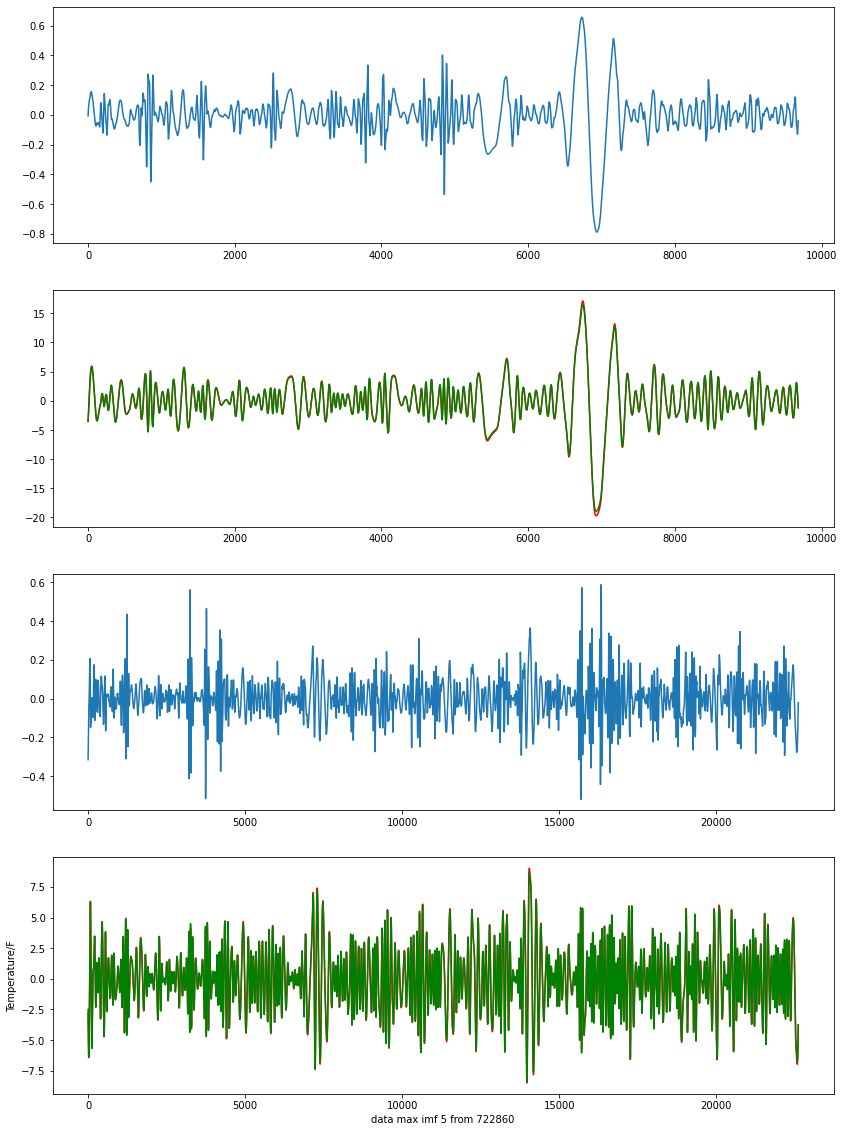

Epoch:10
MSE
TRAIN:0.009650652034951477	TEST:0.02405645481083542
Base_line:0.15227909792836325	DIFFERENT:0.12822264311752782
TARGET:0.019034887241045406
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf5.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________________________________

707/707 [==============================] - 1s 790us/step - loss: 0.5510
Epoch 81/100
707/707 [==============================] - 1s 813us/step - loss: 0.5421
Epoch 82/100
707/707 [==============================] - 1s 741us/step - loss: 0.5258
Epoch 83/100
707/707 [==============================] - 1s 772us/step - loss: 0.5324
Epoch 84/100
707/707 [==============================] - 1s 756us/step - loss: 0.5381
Epoch 85/100
707/707 [==============================] - 1s 750us/step - loss: 0.5375
Epoch 86/100
707/707 [==============================] - 1s 738us/step - loss: 0.5072
Epoch 87/100
707/707 [==============================] - 1s 758us/step - loss: 0.5200
Epoch 88/100
707/707 [==============================] - 1s 805us/step - loss: 0.4964
Epoch 89/100
707/707 [==============================] - 1s 781us/step - loss: 0.5154 0s - loss: 0.516
Epoch 90/100
707/707 [==============================] - 1s 783us/step - loss: 0.4972
Epoch 91/100
707/707 [==============================] - 1s 75

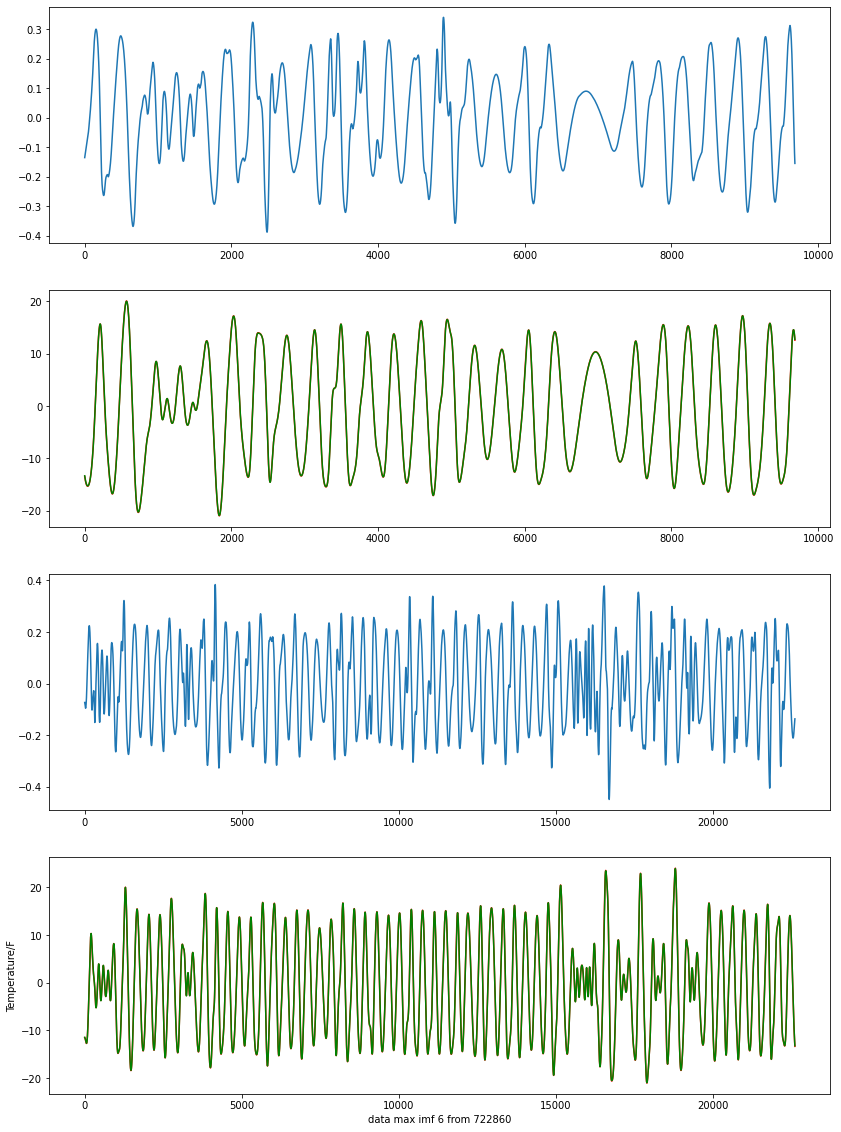

Epoch:1
MSE
TRAIN:0.026612280817743254	TEST:0.02506058323301928
Base_line:0.23363452402998422	DIFFERENT:0.20857394079696495
TARGET:0.033376360575712034
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf6.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
________________________________________________________________

707/707 [==============================] - 1s 1ms/step - loss: 0.5144
Epoch 81/100
707/707 [==============================] - 1s 841us/step - loss: 0.5088
Epoch 82/100
707/707 [==============================] - 1s 756us/step - loss: 0.5088
Epoch 83/100
707/707 [==============================] - 1s 749us/step - loss: 0.4930
Epoch 84/100
707/707 [==============================] - 1s 791us/step - loss: 0.4834
Epoch 85/100
707/707 [==============================] - 1s 758us/step - loss: 0.4841
Epoch 86/100
707/707 [==============================] - 1s 751us/step - loss: 0.5033
Epoch 87/100
707/707 [==============================] - 1s 774us/step - loss: 0.4611
Epoch 88/100
707/707 [==============================] - 1s 781us/step - loss: 0.4729
Epoch 89/100
707/707 [==============================] - 1s 791us/step - loss: 0.4570
Epoch 90/100
707/707 [==============================] - 1s 748us/step - loss: 0.4683
Epoch 91/100
707/707 [==============================] - 1s 743us/step - loss: 0.

707/707 [==============================] - 1s 722us/step - loss: 0.2860
Epoch 21/25
707/707 [==============================] - 1s 725us/step - loss: 0.2901
Epoch 22/25
707/707 [==============================] - 1s 724us/step - loss: 0.2816
Epoch 23/25
707/707 [==============================] - 1s 750us/step - loss: 0.2791
Epoch 24/25
707/707 [==============================] - 1s 716us/step - loss: 0.2834
Epoch 25/25
707/707 [==============================] - 1s 725us/step - loss: 0.2805
Epoch:4
MSE
TRAIN:0.05588850951799845	TEST:0.03498063364101625
Base_line:0.018197613113152312	DIFFERENT:0.01678302052786394
TARGET:0.0030329355188587186
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 781us/step - loss: 0.2836
Epoch 2/25
707/707 [==============================] - 1s 801us/step - loss: 0.2783
Epoch 3/25
707/707 [==============================] - 1s 828us/step - loss: 0.2903
Epoch 4/25
707/707 [==============================] - 1s 770us/step - loss: 0.2804
Epoch 5/25
707

707/707 [==============================] - 1s 967us/step - loss: 0.1994
Epoch 10/25
707/707 [==============================] - 1s 950us/step - loss: 0.1981
Epoch 11/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1970
Epoch 12/25
707/707 [==============================] - 1s 839us/step - loss: 0.2019
Epoch 13/25
707/707 [==============================] - 1s 842us/step - loss: 0.1990
Epoch 14/25
707/707 [==============================] - 1s 913us/step - loss: 0.1986
Epoch 15/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2009
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 0.2006
Epoch 17/25
707/707 [==============================] - 1s 935us/step - loss: 0.2025
Epoch 18/25
707/707 [==============================] - 1s 968us/step - loss: 0.1895
Epoch 19/25
707/707 [==============================] - 1s 1ms/step - loss: 0.1978
Epoch 20/25
707/707 [==============================] - 1s 988us/step - loss: 0.1983
Epoch 21/25


707/707 [==============================] - 1s 781us/step - loss: 0.1491


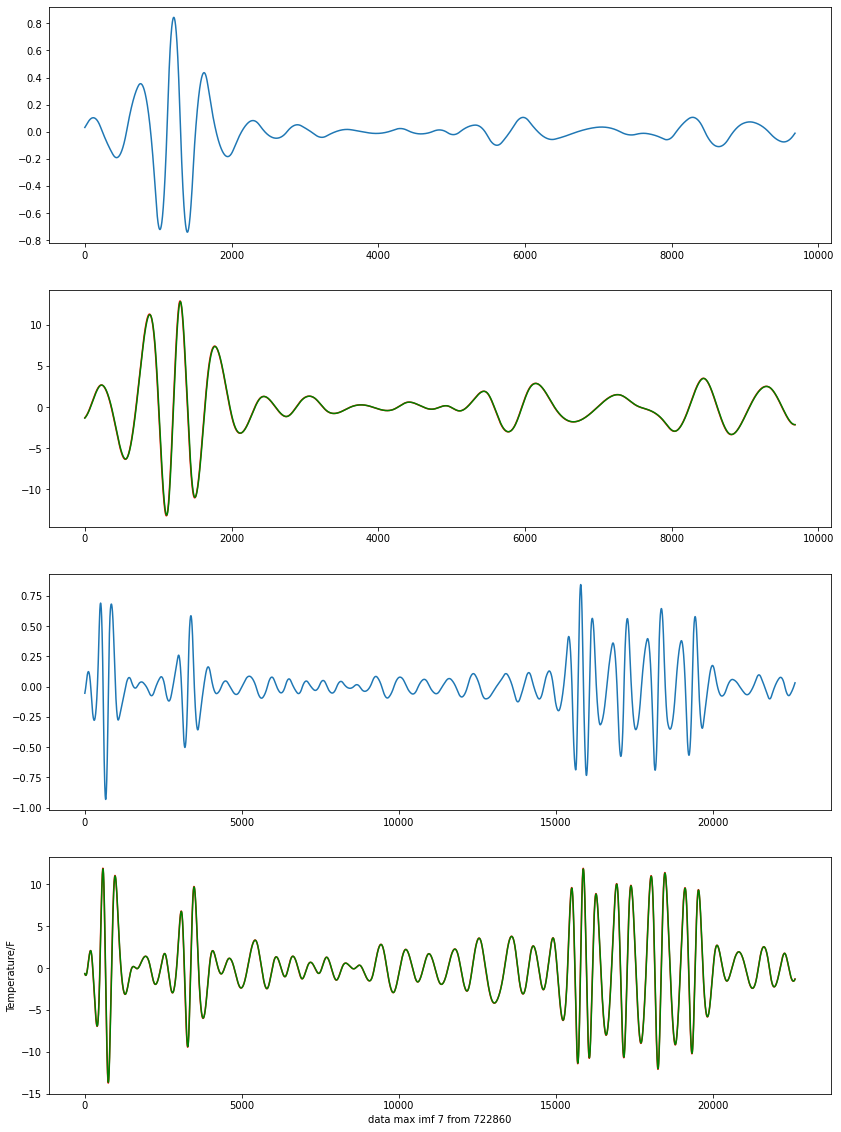

Epoch:10
MSE
TRAIN:0.0419576098391928	TEST:0.026273033196012454
Base_line:0.018197613113152312	DIFFERENT:0.008075420082860142
TARGET:0.0030329355188587186
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf7.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_____________________________________________________________

707/707 [==============================] - 1s 795us/step - loss: 0.1183
Epoch 81/100
707/707 [==============================] - 1s 811us/step - loss: 0.1171
Epoch 82/100
707/707 [==============================] - 1s 816us/step - loss: 0.1170
Epoch 83/100
707/707 [==============================] - 1s 809us/step - loss: 0.1185
Epoch 84/100
707/707 [==============================] - 1s 757us/step - loss: 0.1160
Epoch 85/100
707/707 [==============================] - 1s 762us/step - loss: 0.1158
Epoch 86/100
707/707 [==============================] - 1s 803us/step - loss: 0.1159
Epoch 87/100
707/707 [==============================] - 1s 809us/step - loss: 0.1203
Epoch 88/100
707/707 [==============================] - 1s 803us/step - loss: 0.1146
Epoch 89/100
707/707 [==============================] - 1s 761us/step - loss: 0.1162
Epoch 90/100
707/707 [==============================] - 1s 756us/step - loss: 0.1149
Epoch 91/100
707/707 [==============================] - 1s 758us/step - loss: 

707/707 [==============================] - 1s 778us/step - loss: 0.0981
Epoch 21/25
707/707 [==============================] - 1s 769us/step - loss: 0.0950
Epoch 22/25
707/707 [==============================] - 1s 804us/step - loss: 0.0962
Epoch 23/25
707/707 [==============================] - 1s 866us/step - loss: 0.0965
Epoch 24/25
707/707 [==============================] - 1s 802us/step - loss: 0.0951
Epoch 25/25
707/707 [==============================] - 1s 768us/step - loss: 0.0957
Epoch:4
MSE
TRAIN:0.0006655860344620582	TEST:0.0002690815055345447
Base_line:0.0002536852352798546	DIFFERENT:1.5396270254690086e-05
TARGET:5.073704705597092e-05
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 765us/step - loss: 0.0962
Epoch 2/25
707/707 [==============================] - 1s 780us/step - loss: 0.0946
Epoch 3/25
707/707 [==============================] - 1s 818us/step - loss: 0.0967
Epoch 4/25
707/707 [==============================] - 1s 783us/step - loss: 0.0950
Epoch 

707/707 [==============================] - 1s 816us/step - loss: 0.0827
Epoch 10/25
707/707 [==============================] - 1s 788us/step - loss: 0.0829
Epoch 11/25
707/707 [==============================] - 1s 745us/step - loss: 0.0815
Epoch 12/25
707/707 [==============================] - 1s 767us/step - loss: 0.0802
Epoch 13/25
707/707 [==============================] - 1s 772us/step - loss: 0.0804
Epoch 14/25
707/707 [==============================] - 1s 805us/step - loss: 0.0798
Epoch 15/25
707/707 [==============================] - 1s 776us/step - loss: 0.0808
Epoch 16/25
707/707 [==============================] - 1s 770us/step - loss: 0.0801
Epoch 17/25
707/707 [==============================] - 1s 817us/step - loss: 0.0779
Epoch 18/25
707/707 [==============================] - 1s 838us/step - loss: 0.0798
Epoch 19/25
707/707 [==============================] - 1s 804us/step - loss: 0.0786
Epoch 20/25
707/707 [==============================] - 1s 773us/step - loss: 0.0777
Epoc

707/707 [==============================] - 1s 787us/step - loss: 0.0693


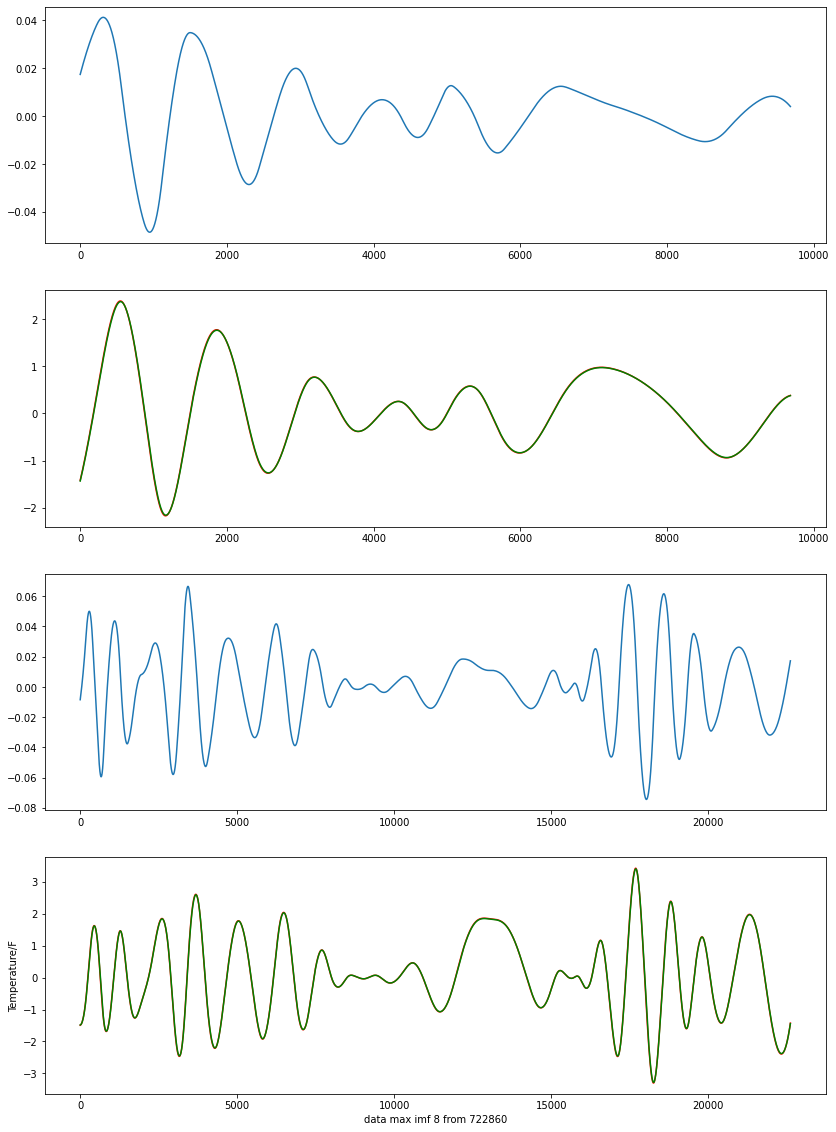

Epoch:10
MSE
TRAIN:0.0006422872123732696	TEST:0.00025959120823286264
Base_line:0.0002536852352798546	DIFFERENT:5.905972953008042e-06
TARGET:5.073704705597092e-05
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf8.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
______________________________________________________

707/707 [==============================] - 1s 782us/step - loss: 0.0473
Epoch 81/100
707/707 [==============================] - 1s 794us/step - loss: 0.0441
Epoch 82/100
707/707 [==============================] - 1s 830us/step - loss: 0.0457
Epoch 83/100
707/707 [==============================] - 1s 765us/step - loss: 0.0467
Epoch 84/100
707/707 [==============================] - 1s 754us/step - loss: 0.0462
Epoch 85/100
707/707 [==============================] - 1s 749us/step - loss: 0.0465
Epoch 86/100
707/707 [==============================] - 1s 779us/step - loss: 0.0463
Epoch 87/100
707/707 [==============================] - 1s 741us/step - loss: 0.0442
Epoch 88/100
707/707 [==============================] - 1s 758us/step - loss: 0.0469
Epoch 89/100
707/707 [==============================] - 1s 780us/step - loss: 0.0479
Epoch 90/100
707/707 [==============================] - 1s 793us/step - loss: 0.0459
Epoch 91/100
707/707 [==============================] - 1s 793us/step - loss: 

707/707 [==============================] - 1s 804us/step - loss: 0.0436
Epoch 21/25
707/707 [==============================] - 1s 757us/step - loss: 0.0429
Epoch 22/25
707/707 [==============================] - 1s 765us/step - loss: 0.0410
Epoch 23/25
707/707 [==============================] - 1s 769us/step - loss: 0.0427
Epoch 24/25
707/707 [==============================] - 1s 791us/step - loss: 0.0421
Epoch 25/25
707/707 [==============================] - 1s 755us/step - loss: 0.0432
Epoch:4
MSE
TRAIN:0.0001182629654537348	TEST:9.882236169262272e-05
Base_line:3.322496196839718e-05	DIFFERENT:6.559739972422554e-05
TARGET:8.306240492099294e-06
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 779us/step - loss: 0.0418
Epoch 2/25
707/707 [==============================] - 1s 809us/step - loss: 0.0428
Epoch 3/25
707/707 [==============================] - 1s 801us/step - loss: 0.0419
Epoch 4/25
707/707 [==============================] - 1s 774us/step - loss: 0.0418
Epoch 5

Epoch 9/25
707/707 [==============================] - 1s 837us/step - loss: 0.0385
Epoch 10/25
707/707 [==============================] - 1s 810us/step - loss: 0.0384
Epoch 11/25
707/707 [==============================] - 1s 843us/step - loss: 0.0378
Epoch 12/25
707/707 [==============================] - 1s 855us/step - loss: 0.0399
Epoch 13/25
707/707 [==============================] - 1s 859us/step - loss: 0.0386
Epoch 14/25
707/707 [==============================] - 1s 833us/step - loss: 0.0393
Epoch 15/25
707/707 [==============================] - 1s 811us/step - loss: 0.0391
Epoch 16/25
707/707 [==============================] - 1s 813us/step - loss: 0.0385
Epoch 17/25
707/707 [==============================] - 1s 837us/step - loss: 0.0389
Epoch 18/25
707/707 [==============================] - 1s 829us/step - loss: 0.0383
Epoch 19/25
707/707 [==============================] - 1s 840us/step - loss: 0.0379
Epoch 20/25
707/707 [==============================] - 1s 871us/step - loss: 

707/707 [==============================] - 1s 761us/step - loss: 0.0370


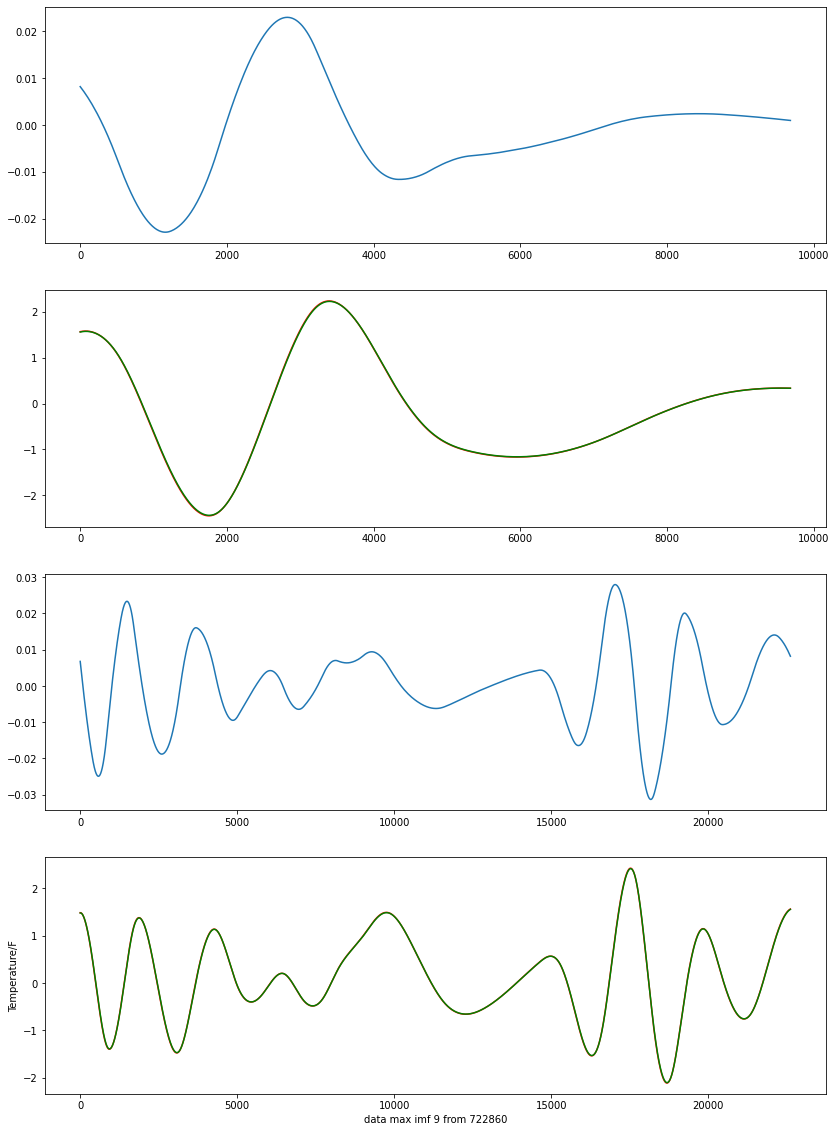

Epoch:10
MSE
TRAIN:0.00012656577644297725	TEST:0.00010963294048465612
Base_line:3.322496196839718e-05	DIFFERENT:7.640797851625895e-05
TARGET:8.306240492099294e-06
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf9.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_____________________________________________________

707/707 [==============================] - 1s 883us/step - loss: 0.0201
Epoch 81/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0191
Epoch 82/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0198
Epoch 83/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0197
Epoch 84/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0201
Epoch 85/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0203
Epoch 86/100
707/707 [==============================] - 1s 939us/step - loss: 0.0192
Epoch 87/100
707/707 [==============================] - 1s 966us/step - loss: 0.0190
Epoch 88/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0193
Epoch 89/100
707/707 [==============================] - 1s 934us/step - loss: 0.0198
Epoch 90/100
707/707 [==============================] - 1s 1ms/step - loss: 0.0198
Epoch 91/100
707/707 [==============================] - 1s 906us/step - loss: 0.0194
Epoch 9

707/707 [==============================] - 1s 1ms/step - loss: 0.0187
Epoch 22/25
707/707 [==============================] - 1s 989us/step - loss: 0.0188
Epoch 23/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0190
Epoch 24/25
707/707 [==============================] - 1s 997us/step - loss: 0.0189
Epoch 25/25
707/707 [==============================] - 1s 981us/step - loss: 0.0186
Epoch:4
MSE
TRAIN:5.297197864679225e-05	TEST:8.081501933636692e-05
Base_line:3.067902590781624e-06	DIFFERENT:7.77471167455853e-05
TARGET:1.022634196927208e-06
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0188
Epoch 2/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0187
Epoch 3/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0186
Epoch 4/25
707/707 [==============================] - 1s 997us/step - loss: 0.0190
Epoch 5/25
707/707 [==============================] - 1s 984us/step - loss: 0.0183
Epoch 6/25
707/707 

707/707 [==============================] - 1s 963us/step - loss: 0.0180
Epoch 11/25
707/707 [==============================] - 1s 970us/step - loss: 0.0180
Epoch 12/25
707/707 [==============================] - 1s 999us/step - loss: 0.0180
Epoch 13/25
707/707 [==============================] - 1s 966us/step - loss: 0.0176
Epoch 14/25
707/707 [==============================] - 1s 999us/step - loss: 0.0180
Epoch 15/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0182
Epoch 16/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0184
Epoch 17/25
707/707 [==============================] - 1s 972us/step - loss: 0.0178
Epoch 18/25
707/707 [==============================] - 1s 960us/step - loss: 0.0184
Epoch 19/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0183
Epoch 20/25
707/707 [==============================] - 1s 968us/step - loss: 0.0180
Epoch 21/25
707/707 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 22/25


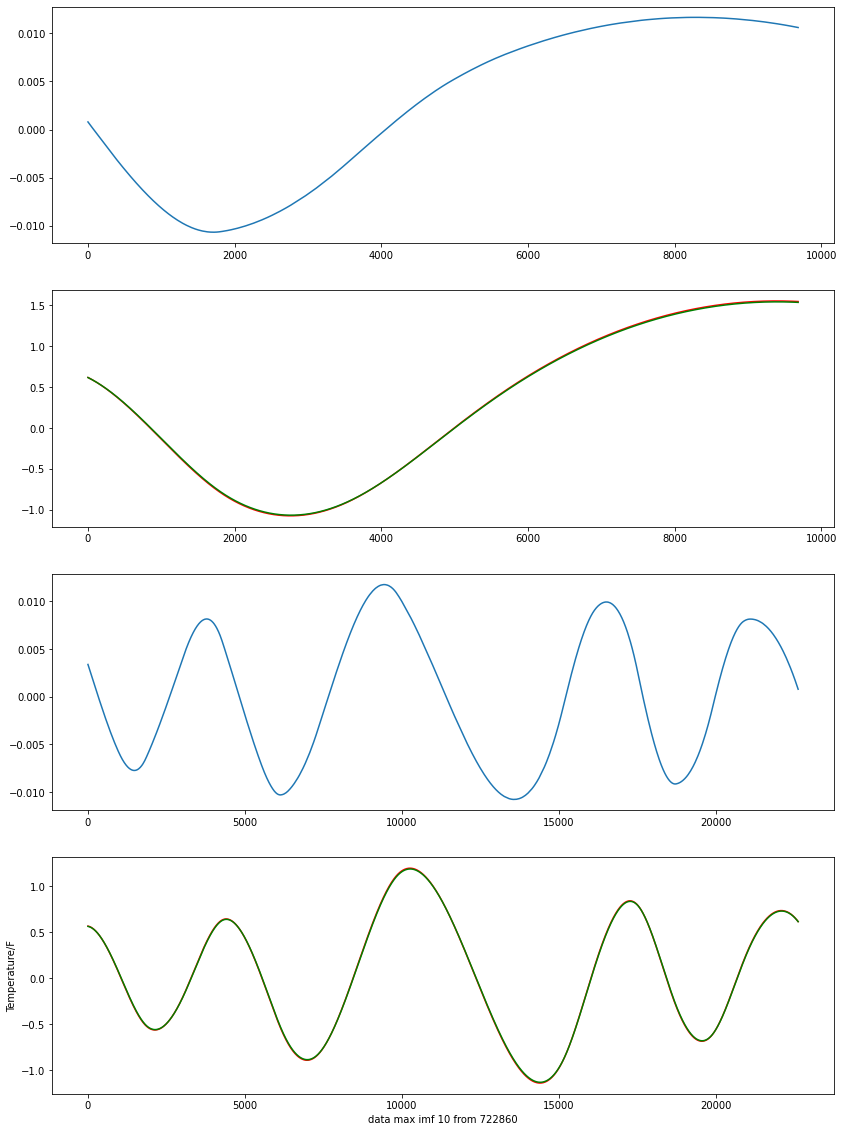

Epoch:10
MSE
TRAIN:4.761476815234009e-05	TEST:7.42647448419003e-05
Base_line:3.067902590781624e-06	DIFFERENT:7.119684225111868e-05
TARGET:1.022634196927208e-06
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf10.params/assets
-------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________________________

707/707 [==============================] - 1s 1ms/step - loss: 11.9954
Epoch 80/100
707/707 [==============================] - 1s 988us/step - loss: 11.7337
Epoch 81/100
707/707 [==============================] - 1s 970us/step - loss: 11.8149
Epoch 82/100
707/707 [==============================] - 1s 979us/step - loss: 11.7816
Epoch 83/100
707/707 [==============================] - 1s 993us/step - loss: 11.8058
Epoch 84/100
707/707 [==============================] - 1s 902us/step - loss: 11.9342
Epoch 85/100
707/707 [==============================] - 1s 861us/step - loss: 11.8085
Epoch 86/100
707/707 [==============================] - 1s 1ms/step - loss: 11.8824
Epoch 87/100
707/707 [==============================] - 1s 1ms/step - loss: 11.9771
Epoch 88/100
707/707 [==============================] - 1s 984us/step - loss: 11.7715
Epoch 89/100
707/707 [==============================] - 1s 994us/step - loss: 12.1903
Epoch 90/100
707/707 [==============================] - 1s 984us/step - l

707/707 [==============================] - 1s 1ms/step - loss: 11.9033
Epoch 20/25
707/707 [==============================] - 1s 1ms/step - loss: 11.9804
Epoch 21/25
707/707 [==============================] - 1s 965us/step - loss: 11.9209
Epoch 22/25
707/707 [==============================] - 1s 974us/step - loss: 11.8499
Epoch 23/25
707/707 [==============================] - 1s 985us/step - loss: 12.0126
Epoch 24/25
707/707 [==============================] - 1s 976us/step - loss: 11.8793
Epoch 25/25
707/707 [==============================] - 1s 1ms/step - loss: 11.6974
Epoch:4
MSE
TRAIN:0.06152627101289738	TEST:0.06760862703664008
Base_line:1.344639385653371e-07	DIFFERENT:0.06760849257270152
TARGET:6.723196928266855e-08
重新训练25次
Epoch 1/25
707/707 [==============================] - 1s 1ms/step - loss: 11.9920
Epoch 2/25
707/707 [==============================] - 1s 975us/step - loss: 11.8445
Epoch 3/25
707/707 [==============================] - 1s 961us/step - loss: 11.7689
Epoch 4/25

707/707 [==============================] - 1s 999us/step - loss: 11.88410s - loss: 11.
Epoch 8/25
707/707 [==============================] - 1s 1ms/step - loss: 11.8478
Epoch 9/25
707/707 [==============================] - 1s 1ms/step - loss: 11.7127
Epoch 10/25
707/707 [==============================] - 1s 969us/step - loss: 11.8764
Epoch 11/25
707/707 [==============================] - 1s 965us/step - loss: 11.7578
Epoch 12/25
707/707 [==============================] - 1s 897us/step - loss: 12.0214
Epoch 13/25
707/707 [==============================] - 1s 874us/step - loss: 11.8517
Epoch 14/25
707/707 [==============================] - 1s 847us/step - loss: 11.9998
Epoch 15/25
707/707 [==============================] - 1s 863us/step - loss: 11.9606
Epoch 16/25
707/707 [==============================] - 1s 962us/step - loss: 11.7273
Epoch 17/25
707/707 [==============================] - 1s 828us/step - loss: 11.8362
Epoch 18/25
707/707 [==============================] - 1s 908us/step 

707/707 [==============================] - 1s 989us/step - loss: 11.9681
Epoch 23/25
707/707 [==============================] - 1s 1ms/step - loss: 11.8494
Epoch 24/25
707/707 [==============================] - 1s 1ms/step - loss: 11.5426
Epoch 25/25
707/707 [==============================] - 1s 969us/step - loss: 11.8948


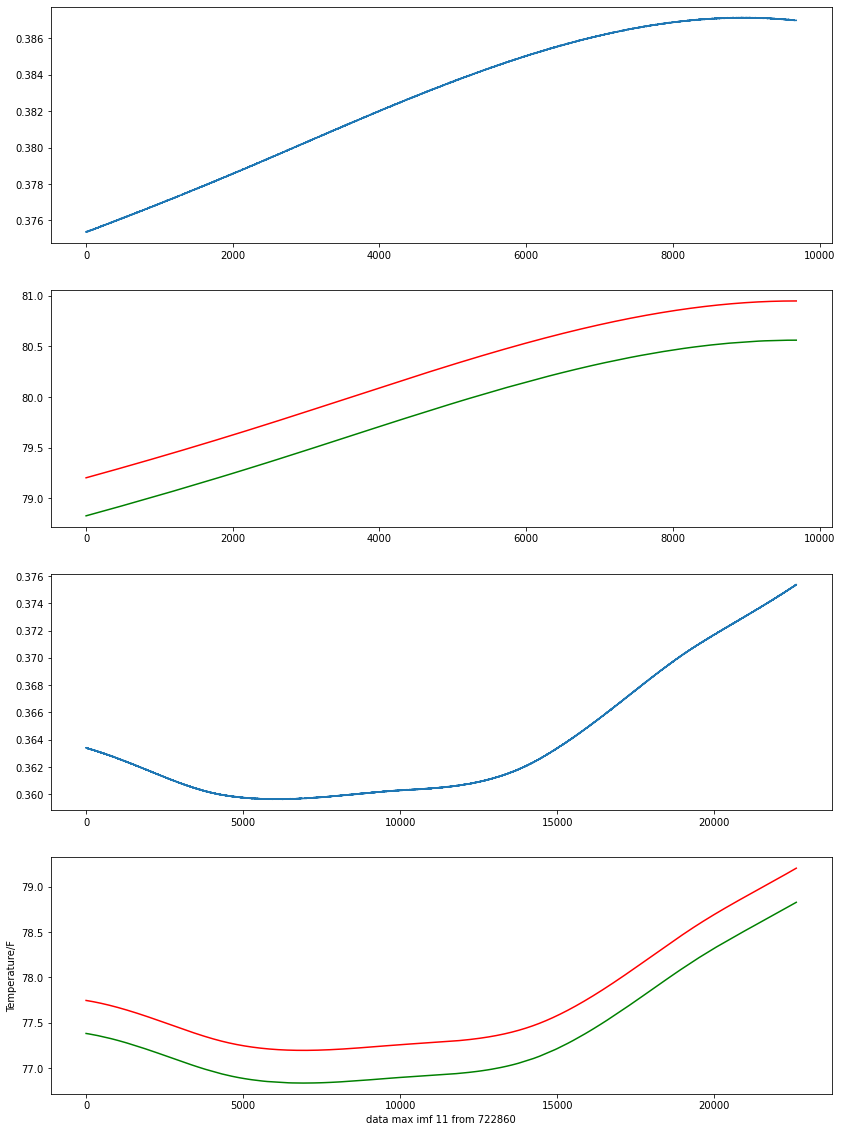

Epoch:10
MSE
TRAIN:0.13236245036133348	TEST:0.14643569715565924
Base_line:1.344639385653371e-07	DIFFERENT:0.14643556269172067
TARGET:6.723196928266855e-08
INFO:tensorflow:Assets written to: ./tf_model_params_1628004895.503316/722860_max_imf11.params/assets
-------------------------------------------------------------------


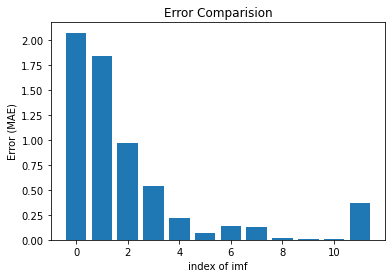

In [19]:
train("max")